# Import packages

In [2]:
%load_ext autoreload
%autoreload 2

import os, sys, sys
from pathlib import Path
for p in [Path.cwd()] + list(Path.cwd().parents):
    if p.name == 'Multifirefly-Project':
        os.chdir(p)
        sys.path.insert(0, str(p / 'multiff_analysis/multiff_code/methods'))
        break
    
from data_wrangling import specific_utils, process_monkey_information, general_utils, combine_info_utils
from pattern_discovery import pattern_by_trials, pattern_by_trials, cluster_analysis, organize_patterns_and_features
from visualization.matplotlib_tools import plot_behaviors_utils
from neural_data_analysis.neural_analysis_tools.get_neural_data import neural_data_processing
from neural_data_analysis.neural_analysis_tools.visualize_neural_data import plot_neural_data, plot_modeling_result
from neural_data_analysis.neural_analysis_tools.model_neural_data import transform_vars, neural_data_modeling, drop_high_corr_vars, drop_high_vif_vars
from neural_data_analysis.topic_based_neural_analysis.neural_vs_behavioral import prep_monkey_data, prep_target_data, neural_vs_behavioral_class
from neural_data_analysis.topic_based_neural_analysis.planning_and_neural import planning_and_neural_class, pn_utils, pn_helper_class, pn_aligned_by_seg, pn_aligned_by_event
from neural_data_analysis.neural_analysis_tools.cca_methods import cca_class
from neural_data_analysis.neural_analysis_tools.cca_methods import cca_class, cca_utils, cca_cv_utils
from neural_data_analysis.neural_analysis_tools.cca_methods.cca_plotting import cca_plotting, cca_plot_lag_vs_no_lag, cca_plot_cv
from machine_learning.ml_methods import regression_utils, regz_regression_utils, ml_methods_class, classification_utils, ml_plotting_utils, ml_methods_utils
from planning_analysis.show_planning import nxt_ff_utils, show_planning_utils
from neural_data_analysis.neural_analysis_tools.gpfa_methods import elephant_utils, fit_gpfa_utils, plot_gpfa_utils, gpfa_helper_class
from neural_data_analysis.neural_analysis_tools.align_trials import time_resolved_regression, time_resolved_gpfa_regression,plot_time_resolved_regression
from neural_data_analysis.neural_analysis_tools.align_trials import align_trial_utils


import sys
import math
import gc
import subprocess
from pathlib import Path
from importlib import reload

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from scipy import linalg, interpolate
from scipy.signal import fftconvolve
from scipy.io import loadmat
from scipy import sparse
import torch
from numpy import pi

# Machine Learning imports
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.multivariate.cancorr import CanCorr

# Neuroscience specific imports
import neo
import rcca
import quantities as pq

plt.rcParams["animation.html"] = "html5"
os.environ['KMP_DUPLICATE_LIB_OK']='True'
rc('animation', html='jshtml')
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['animation.embed_limit'] = 2**128
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
print("done")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
done
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# specs and funcs

In [3]:

key_feats = [
'new_bin', 'new_segment', 'whether_test',
'cur_opt_arc_dheading',
'cur_ff_distance',
'cur_ff_rel_x',
'cur_ff_rel_y',
'nxt_ff_rel_x',
'nxt_ff_rel_y',
'nxt_ff_distance',
'num_ff_visible',
'num_ff_in_memory',
'cur_ff_distance_at_ref',
'cur_ff_angle_boundary_at_ref',
'nxt_ff_distance_at_ref',
'ang_speed',
'speed',
'accel',
'ang_accel',
'monkey_speeddummy',
'curv_of_traj',
'angle_from_cur_ff_to_nxt_ff',
'time_since_last_capture',
'bin_mid_time_rel_to_event',
'time', 
'target_index',
# categorical modeling for the below:
'cur_vis',
'nxt_vis',
'nxt_in_memory',
'any_ff_visible',
# 'cur_in_memory', # don't used those two cause they will just be one
# 'any_ff_in_memory',

]



def _prep_behav(df, key_feats,
                cont_cols=('cur_ff_distance', 'nxt_ff_distance', 'time_since_last_capture'),
                cat_vars=('cur_vis', 'nxt_vis', 'nxt_in_memory', 'any_ff_visible')):
    # keep only requested features (that exist), copy to avoid side effects
    keep = [c for c in key_feats if c in df.columns]
    out = df.loc[:, keep].copy()

    # add log1p features (clip negatives to 0 to keep log1p valid)
    for c in cont_cols:
        if c in out.columns:
            out[f'log1p_{c}'] = np.log1p(pd.to_numeric(out[c], errors='coerce').clip(lower=0))

    # binarize categorical indicators ( > 0 → 1; else 0 )
    for v in cat_vars:
        if v in out.columns:
            x = pd.to_numeric(out[v], errors='coerce')
            out[v] = (x.fillna(0) > 0).astype('int8')

    return out

# TRY GPFA NEXT!!!!!!!!!!

# retrieve data

In [4]:
use_raw_spike_data_instead=True
apply_pca_on_raw_spike_data=False
use_lagged_raw_spike_data=True

data_0219
Loaded binned_spikes_df from all_monkey_data/processed_neural_data/monkey_Bruno/data_0219/binned_spikes_df_0p1.csv
Loaded planning_data_by_point from all_monkey_data/planning_and_neural/monkey_Bruno/data_0219/planning_data_by_point/opt_arc_stop_closest/test/cur_vis_0_1_window_-25cm_0cm
Loaded planning_data_by_point from all_monkey_data/planning_and_neural/monkey_Bruno/data_0219/planning_data_by_point/opt_arc_stop_closest/control/cur_vis_0_1_window_-25cm_0cm
Loaded behav_data_by_bin from all_monkey_data/target_decoder/monkey_Bruno/data_0219/behav_data_by_point.csv
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Dropped 7 columns with more than 50.0% missing values: ['stop_id_duration', 'stop_cluster_size', 'stop_id_start_time', 'stop_cluster_start_point', 'stop_cluster_id', 'stop_cluster_end_point', 'stop_id_end_time']
0.22% of rows are dropped in plan

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)
/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the g

Removing 2 columns with zero variance: ['cluster_2_4', 'cluster_2_5']
x_var.shape: (8976, 26)
y_var.shape: (8976, 37)
x_var_reduced.shape: (8976, 26)
y_var_reduced.shape: (8976, 33)
x_var_lags.shape: (8976, 277)
y_var_lags.shape: (8976, 398)
new_seg_duration is now 1.0, and post_event_window is now 0.75
Loaded new_seg_info from all_monkey_data/planning_and_neural/monkey_Bruno/data_0219/new_seg_info/tlim2_cur_first_pre0p25_post0p75.csv
Dropped 43 columns due to containing NA in rebinned_y_var via calling drop_na_cols function: ['nxt_opt_arc_curv', 'cur_cntr_arc_curv', 'nxt_cntr_arc_curv', 'cur_opt_arc_curv', 'cur_opt_arc_end_heading', 'angle_opt_cur_end_to_nxt_ff', 'angle_from_stop_to_nxt_ff', 'diff_in_angle_to_nxt_ff', 'diff_in_abs_angle_to_nxt_ff', 'traj_curv_to_stop', 'curv_from_stop_to_nxt_ff', 'opt_curv_to_cur_ff', 'curv_from_cur_end_to_nxt_ff', 'd_curv_null_arc', 'd_curv_monkey', 'abs_d_curv_null_arc', 'abs_d_curv_monkey', 'diff_in_d_curv', 'diff_in_abs_d_curv', 'abs_angle_opt_cur

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)


Made rebinned_x_var, rebinned_y_var, rebinned_x_var_lags, and rebinned_y_var_lags.

No NA values found in concat_neural_trials

No NA values found in concat_behav_trials
Rank deficiency detected: 13 redundant neurons
Matrix shape: (348, 96), Rank: 83
Smallest singular values:
[0. 0. 0. 0. 0.]
Dropping redundant neuron: cluster_22_-1
Rank deficiency detected: 12 redundant neurons
Matrix shape: (348, 95), Rank: 83
Smallest singular values:
[0. 0. 0. 0. 0.]
Dropping redundant neuron: cluster_6_0
Rank deficiency detected: 11 redundant neurons
Matrix shape: (348, 94), Rank: 83
Smallest singular values:
[0. 0. 0. 0. 0.]
Dropping redundant neuron: cluster_2_-1
Rank deficiency detected: 10 redundant neurons
Matrix shape: (348, 93), Rank: 83
Smallest singular values:
[0. 0. 0. 0. 0.]
Dropping redundant neuron: cluster_2_0
Rank deficiency detected: 9 redundant neurons
Matrix shape: (348, 92), Rank: 83
Smallest singular values:
[0. 0. 0. 0. 0.]
Dropping redundant neuron: cluster_22_-3
Rank defici

/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

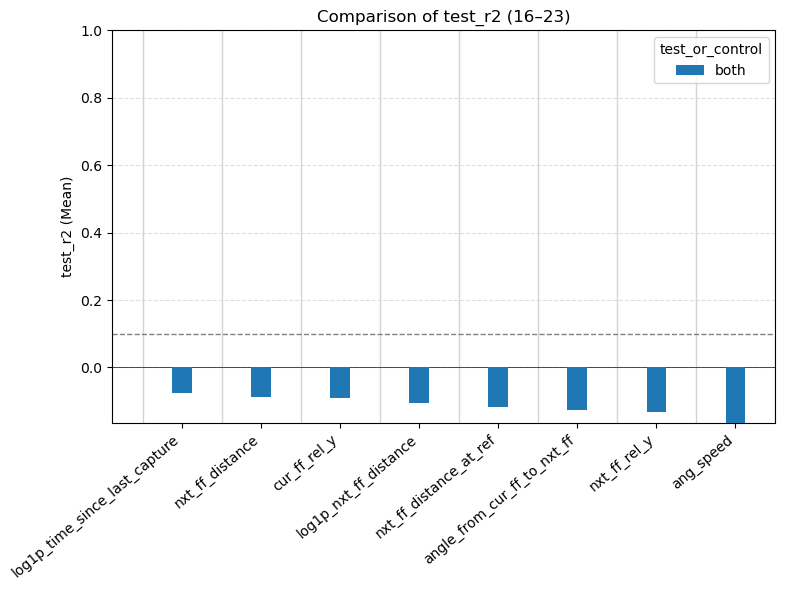

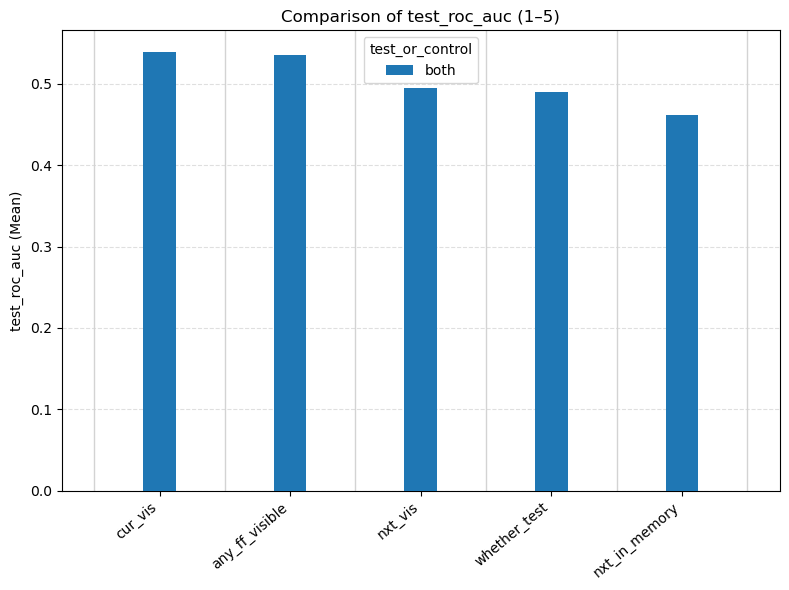

data_0220
Loaded binned_spikes_df from all_monkey_data/processed_neural_data/monkey_Bruno/data_0220/binned_spikes_df_0p1.csv
Loaded planning_data_by_point from all_monkey_data/planning_and_neural/monkey_Bruno/data_0220/planning_data_by_point/opt_arc_stop_closest/test/cur_vis_0_1_window_-25cm_0cm
Loaded planning_data_by_point from all_monkey_data/planning_and_neural/monkey_Bruno/data_0220/planning_data_by_point/opt_arc_stop_closest/control/cur_vis_0_1_window_-25cm_0cm
Loaded behav_data_by_bin from all_monkey_data/target_decoder/monkey_Bruno/data_0220/behav_data_by_point.csv
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Dropped 7 columns with more than 50.0% missing values: ['stop_id_duration', 'stop_cluster_size', 'stop_id_start_time', 'stop_cluster_start_point', 'stop_cluster_id', 'stop_cluster_end_point', 'stop_id_end_time']
0.24% of rows are dropped in plan

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)
/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the g

x_var.shape: (4690, 15)
y_var.shape: (4690, 37)
x_var_reduced.shape: (4690, 15)
y_var_reduced.shape: (4690, 32)
x_var_lags.shape: (4690, 156)
y_var_lags.shape: (4690, 398)
new_seg_duration is now 1.0, and post_event_window is now 0.75
Loaded new_seg_info from all_monkey_data/planning_and_neural/monkey_Bruno/data_0220/new_seg_info/tlim2_cur_first_pre0p25_post0p75.csv
Dropped 43 columns due to containing NA in rebinned_y_var via calling drop_na_cols function: ['nxt_cntr_arc_curv', 'nxt_opt_arc_curv', 'cur_opt_arc_curv', 'cur_cntr_arc_curv', 'cur_opt_arc_end_heading', 'angle_opt_cur_end_to_nxt_ff', 'angle_from_stop_to_nxt_ff', 'diff_in_angle_to_nxt_ff', 'diff_in_abs_angle_to_nxt_ff', 'traj_curv_to_stop', 'curv_from_stop_to_nxt_ff', 'opt_curv_to_cur_ff', 'curv_from_cur_end_to_nxt_ff', 'd_curv_null_arc', 'd_curv_monkey', 'abs_d_curv_null_arc', 'abs_d_curv_monkey', 'diff_in_d_curv', 'diff_in_abs_d_curv', 'abs_angle_opt_cur_end_to_nxt_ff', 'abs_angle_from_stop_to_nxt_ff', 'abs_diff_in_angle_t

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)



No NA values found in concat_neural_trials

No NA values found in concat_behav_trials
Rank deficiency detected: 3 redundant neurons
Matrix shape: (199, 52), Rank: 49
Smallest singular values:
[0.      0.      0.      0.42261 0.7715 ]
Dropping redundant neuron: cluster_1_-3
Rank deficiency detected: 2 redundant neurons
Matrix shape: (199, 51), Rank: 49
Smallest singular values:
[0.      0.      0.42261 0.7715  0.80639]
Dropping redundant neuron: cluster_1_-2
Rank deficiency detected: 1 redundant neurons
Matrix shape: (199, 50), Rank: 49
Smallest singular values:
[0.      0.42261 0.7715  0.80639 1.19181]
Dropping redundant neuron: cluster_1_0

No NA values found in concat_neural_trials

No NA values found in concat_behav_trials

=== Data Dimensions Summary ===
Total number of trials: 199

Concatenated Data Shapes (total n_timepoints × n_features):
  concat_neural_trials:     (1955, 51)
  concat_behav_trials:      (1955, 33)
test_or_control: both
x_var dimensions: (1361, 49)
y_var dimens

/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


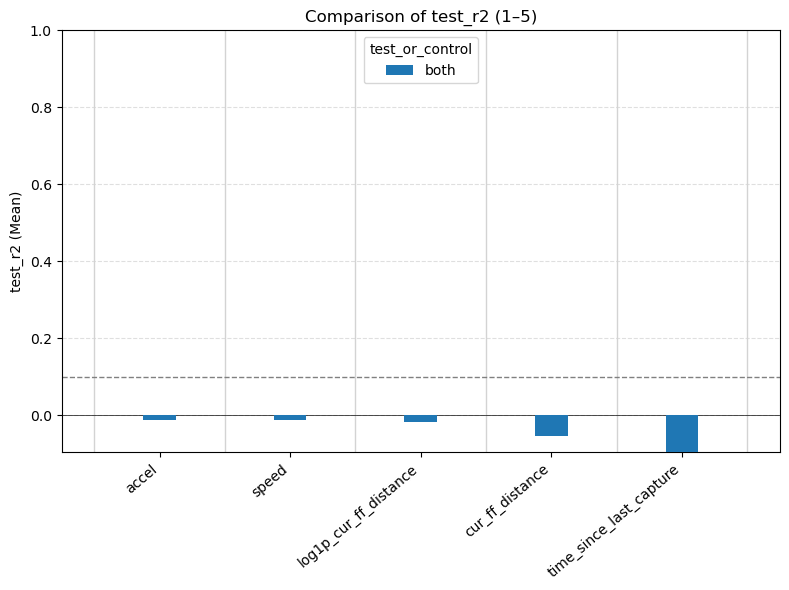

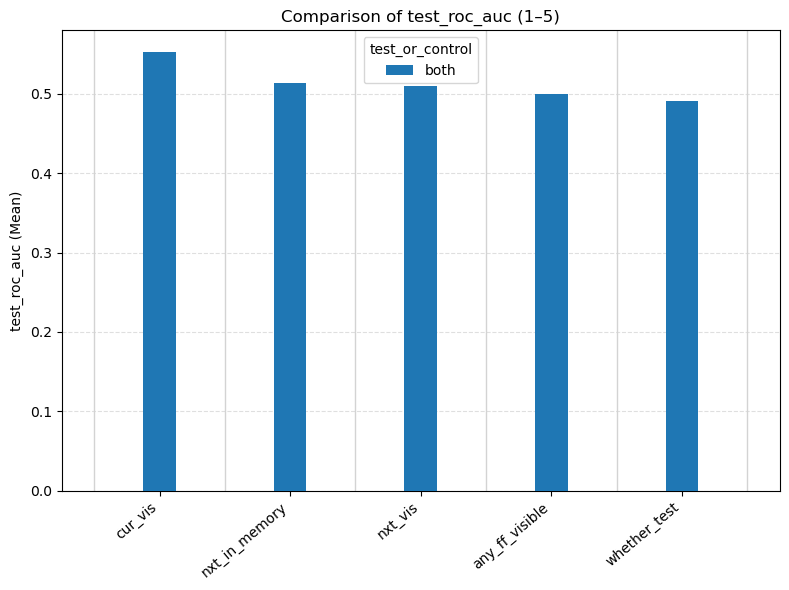

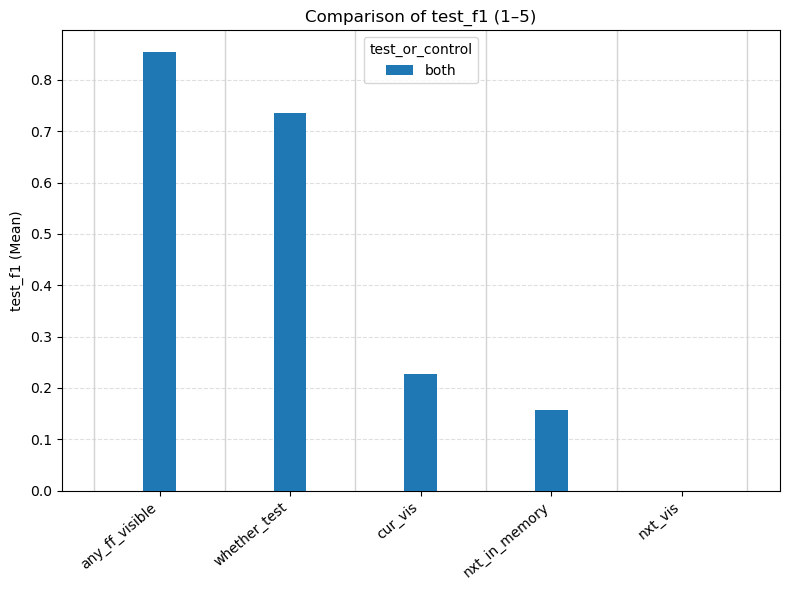

data_0221
Loaded binned_spikes_df from all_monkey_data/processed_neural_data/monkey_Bruno/data_0221/binned_spikes_df_0p1.csv
Loaded planning_data_by_point from all_monkey_data/planning_and_neural/monkey_Bruno/data_0221/planning_data_by_point/opt_arc_stop_closest/test/cur_vis_0_1_window_-25cm_0cm
Loaded planning_data_by_point from all_monkey_data/planning_and_neural/monkey_Bruno/data_0221/planning_data_by_point/opt_arc_stop_closest/control/cur_vis_0_1_window_-25cm_0cm
Loaded behav_data_by_bin from all_monkey_data/target_decoder/monkey_Bruno/data_0221/behav_data_by_point.csv
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Dropped 7 columns with more than 50.0% missing values: ['stop_id_duration', 'stop_cluster_size', 'stop_id_start_time', 'stop_cluster_start_point', 'stop_cluster_id', 'stop_cluster_end_point', 'stop_id_end_time']
0.24% of rows are dropped in plan

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)
/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the g

Removing 88 columns with zero variance: ['cluster_1_0', 'cluster_3_0', 'cluster_4_0', 'cluster_15_0', 'cluster_23_0', 'cluster_27_0', 'cluster_29_0', 'cluster_33_0', 'cluster_1_-1', 'cluster_3_-1', 'cluster_4_-1', 'cluster_15_-1', 'cluster_23_-1', 'cluster_27_-1', 'cluster_29_-1', 'cluster_33_-1', 'cluster_1_1', 'cluster_3_1', 'cluster_4_1', 'cluster_15_1', 'cluster_23_1', 'cluster_27_1', 'cluster_29_1', 'cluster_33_1', 'cluster_1_-2', 'cluster_3_-2', 'cluster_4_-2', 'cluster_15_-2', 'cluster_23_-2', 'cluster_27_-2', 'cluster_29_-2', 'cluster_33_-2', 'cluster_1_2', 'cluster_3_2', 'cluster_4_2', 'cluster_15_2', 'cluster_23_2', 'cluster_27_2', 'cluster_29_2', 'cluster_33_2', 'cluster_1_-3', 'cluster_3_-3', 'cluster_4_-3', 'cluster_15_-3', 'cluster_23_-3', 'cluster_27_-3', 'cluster_29_-3', 'cluster_33_-3', 'cluster_1_3', 'cluster_3_3', 'cluster_4_3', 'cluster_15_3', 'cluster_23_3', 'cluster_27_3', 'cluster_29_3', 'cluster_33_3', 'cluster_1_-4', 'cluster_3_-4', 'cluster_4_-4', 'cluster_15_

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)


Made rebinned_x_var, rebinned_y_var, rebinned_x_var_lags, and rebinned_y_var_lags.

No NA values found in concat_neural_trials

No NA values found in concat_behav_trials
Rank deficiency detected: 22 redundant neurons
Matrix shape: (361, 112), Rank: 90
Smallest singular values:
[0. 0. 0. 0. 0.]
Dropping redundant neuron: cluster_32_-3
Rank deficiency detected: 21 redundant neurons
Matrix shape: (361, 111), Rank: 90
Smallest singular values:
[0. 0. 0. 0. 0.]
Dropping redundant neuron: cluster_0_-2
Rank deficiency detected: 20 redundant neurons
Matrix shape: (361, 110), Rank: 90
Smallest singular values:
[0. 0. 0. 0. 0.]
Dropping redundant neuron: cluster_17_-3
Rank deficiency detected: 19 redundant neurons
Matrix shape: (361, 109), Rank: 90
Smallest singular values:
[0. 0. 0. 0. 0.]
Dropping redundant neuron: cluster_32_-2
Rank deficiency detected: 18 redundant neurons
Matrix shape: (361, 108), Rank: 90
Smallest singular values:
[0. 0. 0. 0. 0.]
Dropping redundant neuron: cluster_30_-2
R

/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

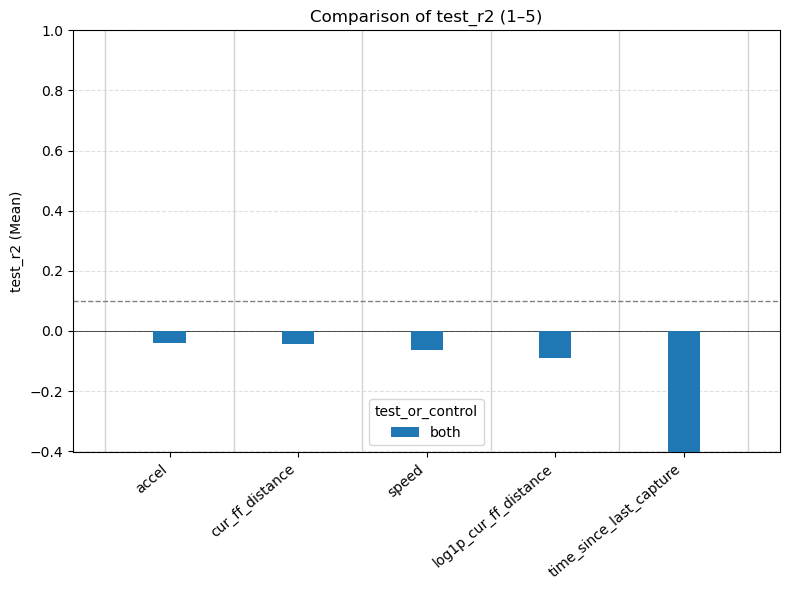

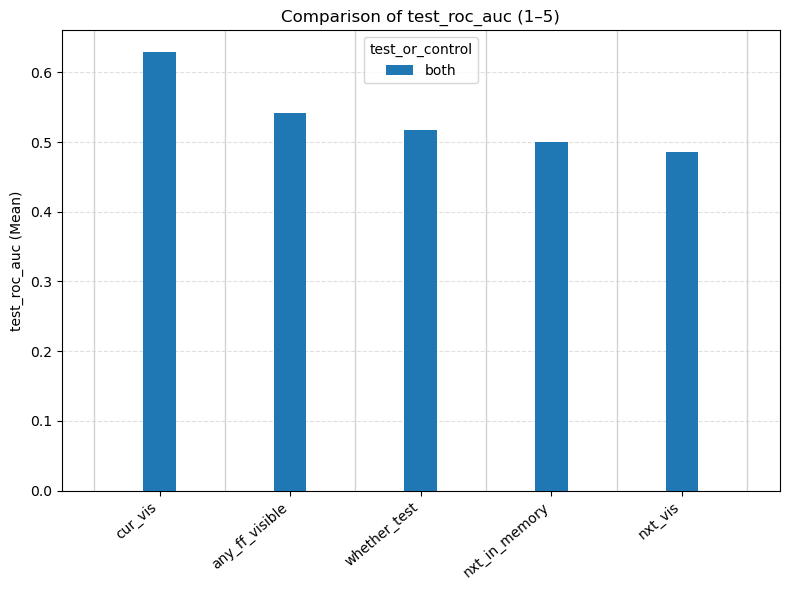

data_0222
Loaded binned_spikes_df from all_monkey_data/processed_neural_data/monkey_Bruno/data_0222/binned_spikes_df_0p1.csv
Loaded planning_data_by_point from all_monkey_data/planning_and_neural/monkey_Bruno/data_0222/planning_data_by_point/opt_arc_stop_closest/test/cur_vis_0_1_window_-25cm_0cm
Loaded planning_data_by_point from all_monkey_data/planning_and_neural/monkey_Bruno/data_0222/planning_data_by_point/opt_arc_stop_closest/control/cur_vis_0_1_window_-25cm_0cm
Loaded behav_data_by_bin from all_monkey_data/target_decoder/monkey_Bruno/data_0222/behav_data_by_point.csv
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Dropped 7 columns with more than 50.0% missing values: ['stop_id_duration', 'stop_cluster_size', 'stop_id_start_time', 'stop_cluster_start_point', 'stop_cluster_id', 'stop_cluster_end_point', 'stop_id_end_time']
0.25% of rows are dropped in plan

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)
/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the g

x_var.shape: (8992, 20)
y_var.shape: (8992, 37)
x_var_reduced.shape: (8992, 20)
y_var_reduced.shape: (8992, 33)
x_var_lags.shape: (8992, 211)
y_var_lags.shape: (8992, 398)
new_seg_duration is now 1.0, and post_event_window is now 0.75
Loaded new_seg_info from all_monkey_data/planning_and_neural/monkey_Bruno/data_0222/new_seg_info/tlim2_cur_first_pre0p25_post0p75.csv
Dropped 43 columns due to containing NA in rebinned_y_var via calling drop_na_cols function: ['nxt_cntr_arc_curv', 'nxt_opt_arc_curv', 'cur_cntr_arc_curv', 'cur_opt_arc_curv', 'cur_opt_arc_end_heading', 'angle_opt_cur_end_to_nxt_ff', 'angle_from_stop_to_nxt_ff', 'diff_in_angle_to_nxt_ff', 'diff_in_abs_angle_to_nxt_ff', 'traj_curv_to_stop', 'curv_from_stop_to_nxt_ff', 'opt_curv_to_cur_ff', 'curv_from_cur_end_to_nxt_ff', 'd_curv_null_arc', 'd_curv_monkey', 'abs_d_curv_null_arc', 'abs_d_curv_monkey', 'diff_in_d_curv', 'diff_in_abs_d_curv', 'abs_angle_opt_cur_end_to_nxt_ff', 'abs_angle_from_stop_to_nxt_ff', 'abs_diff_in_angle_t

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)


Rank deficiency detected: 1 redundant neurons
Matrix shape: (343, 17), Rank: 16
Smallest singular values:
[ 0.       4.50163  5.84936  7.49898 10.42646]
Dropping redundant neuron: cluster_7

No NA values found in concat_neural_trials

No NA values found in concat_behav_trials
Rank deficiency detected: 7 redundant neurons
Matrix shape: (343, 68), Rank: 61
Smallest singular values:
[0. 0. 0. 0. 0.]
Dropping redundant neuron: cluster_15_-2
Rank deficiency detected: 6 redundant neurons
Matrix shape: (343, 67), Rank: 61
Smallest singular values:
[0. 0. 0. 0. 0.]
Dropping redundant neuron: cluster_7_-2
Rank deficiency detected: 5 redundant neurons
Matrix shape: (343, 66), Rank: 61
Smallest singular values:
[0. 0. 0. 0. 0.]
Dropping redundant neuron: cluster_7_0
Rank deficiency detected: 4 redundant neurons
Matrix shape: (343, 65), Rank: 61
Smallest singular values:
[0.      0.      0.      0.      0.61878]
Dropping redundant neuron: cluster_7_-1
Rank deficiency detected: 3 redundant neurons


/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

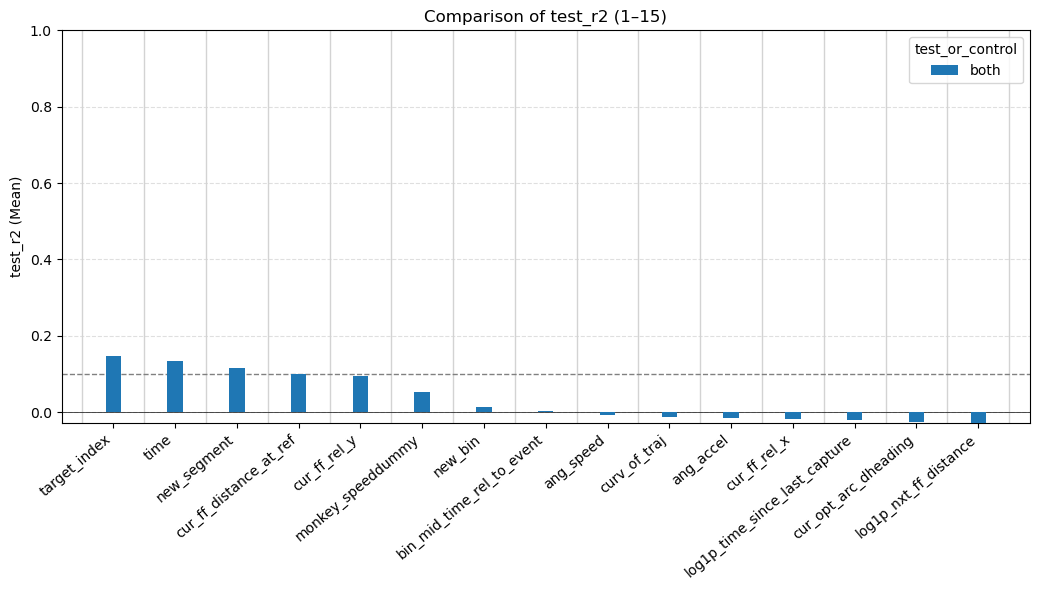

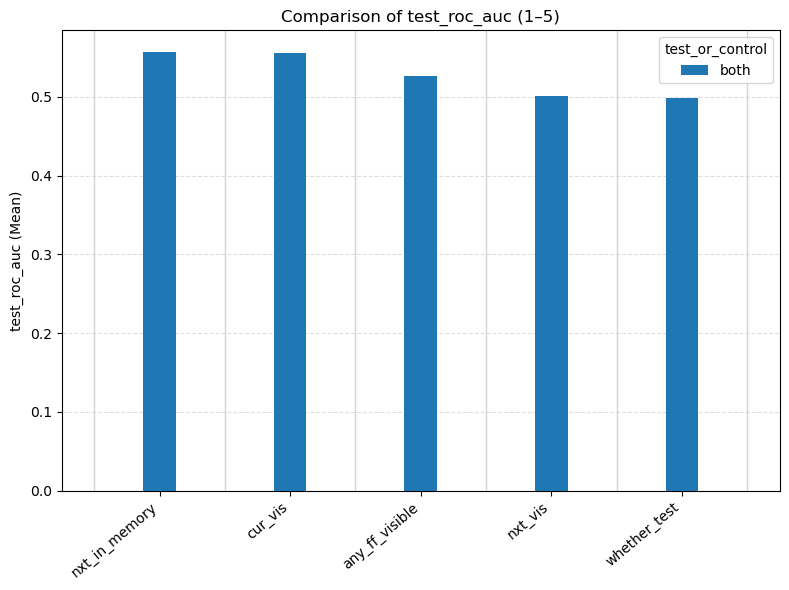

data_0226
Loaded binned_spikes_df from all_monkey_data/processed_neural_data/monkey_Bruno/data_0226/binned_spikes_df_0p1.csv
Loaded planning_data_by_point from all_monkey_data/planning_and_neural/monkey_Bruno/data_0226/planning_data_by_point/opt_arc_stop_closest/test/cur_vis_0_1_window_-25cm_0cm
Loaded planning_data_by_point from all_monkey_data/planning_and_neural/monkey_Bruno/data_0226/planning_data_by_point/opt_arc_stop_closest/control/cur_vis_0_1_window_-25cm_0cm
Loaded behav_data_by_bin from all_monkey_data/target_decoder/monkey_Bruno/data_0226/behav_data_by_point.csv
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Dropped 7 columns with more than 50.0% missing values: ['stop_id_duration', 'stop_cluster_size', 'stop_id_start_time', 'stop_cluster_start_point', 'stop_cluster_id', 'stop_cluster_end_point', 'stop_id_end_time']
0.21% of rows are dropped in plan

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)
/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the g

x_var.shape: (8338, 12)
y_var.shape: (8338, 37)
x_var_reduced.shape: (8338, 12)
y_var_reduced.shape: (8338, 34)
x_var_lags.shape: (8338, 123)
y_var_lags.shape: (8338, 398)
new_seg_duration is now 1.0, and post_event_window is now 0.75
Loaded new_seg_info from all_monkey_data/planning_and_neural/monkey_Bruno/data_0226/new_seg_info/tlim2_cur_first_pre0p25_post0p75.csv
Dropped 43 columns due to containing NA in rebinned_y_var via calling drop_na_cols function: ['nxt_cntr_arc_curv', 'nxt_opt_arc_curv', 'cur_opt_arc_curv', 'cur_cntr_arc_curv', 'cur_opt_arc_end_heading', 'angle_opt_cur_end_to_nxt_ff', 'angle_from_stop_to_nxt_ff', 'diff_in_angle_to_nxt_ff', 'diff_in_abs_angle_to_nxt_ff', 'traj_curv_to_stop', 'curv_from_stop_to_nxt_ff', 'opt_curv_to_cur_ff', 'curv_from_cur_end_to_nxt_ff', 'd_curv_null_arc', 'd_curv_monkey', 'abs_d_curv_null_arc', 'abs_d_curv_monkey', 'diff_in_d_curv', 'diff_in_abs_d_curv', 'abs_angle_opt_cur_end_to_nxt_ff', 'abs_angle_from_stop_to_nxt_ff', 'abs_diff_in_angle_t

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)



No NA values found in concat_neural_trials

No NA values found in concat_behav_trials

No NA values found in concat_neural_trials

No NA values found in concat_behav_trials

=== Data Dimensions Summary ===
Total number of trials: 314

Concatenated Data Shapes (total n_timepoints × n_features):
  concat_neural_trials:     (3093, 42)
  concat_behav_trials:      (3093, 33)
test_or_control: both
x_var dimensions: (2167, 40)
y_var dimensions: (2167, 33)


/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

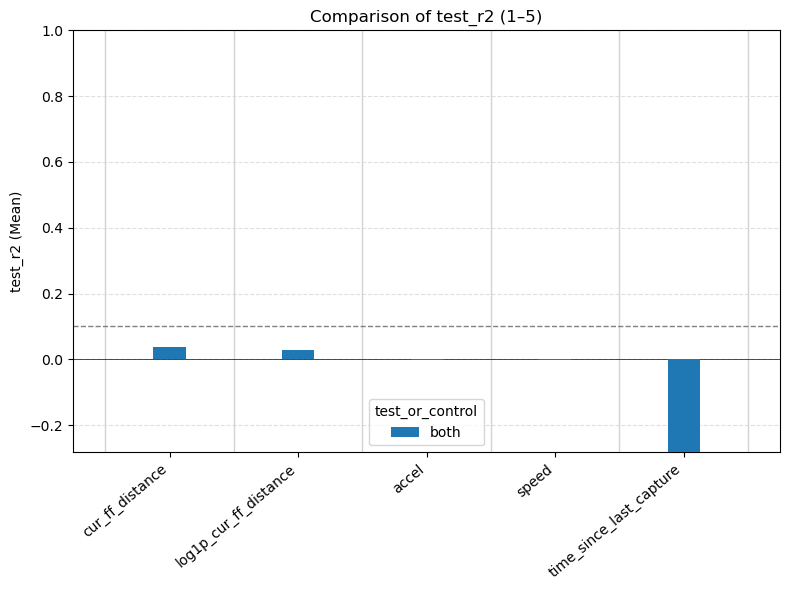

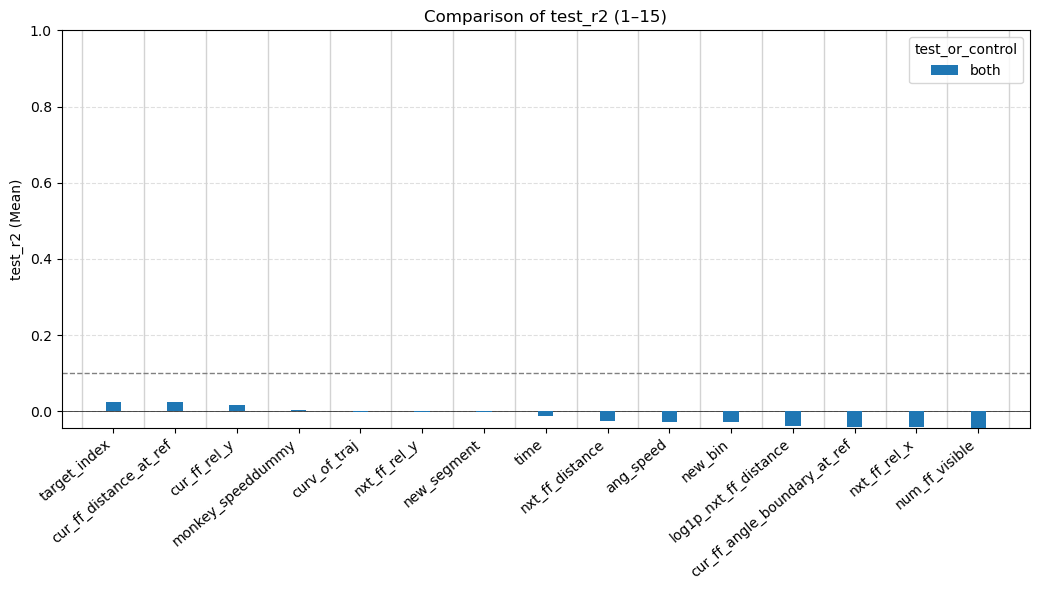

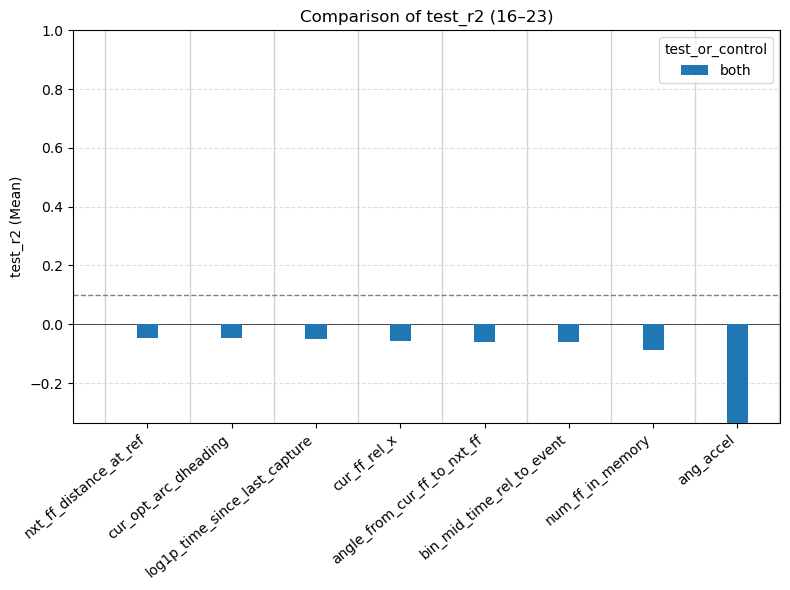

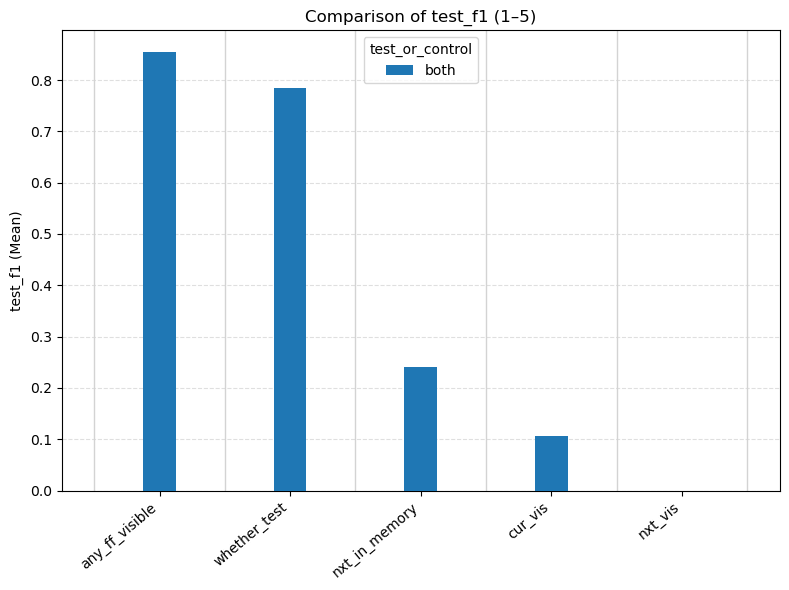

data_0227
Loaded binned_spikes_df from all_monkey_data/processed_neural_data/monkey_Bruno/data_0227/binned_spikes_df_0p1.csv
Loaded planning_data_by_point from all_monkey_data/planning_and_neural/monkey_Bruno/data_0227/planning_data_by_point/opt_arc_stop_closest/test/cur_vis_0_1_window_-25cm_0cm
Loaded planning_data_by_point from all_monkey_data/planning_and_neural/monkey_Bruno/data_0227/planning_data_by_point/opt_arc_stop_closest/control/cur_vis_0_1_window_-25cm_0cm
Loaded behav_data_by_bin from all_monkey_data/target_decoder/monkey_Bruno/data_0227/behav_data_by_point.csv
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Dropped 7 columns with more than 50.0% missing values: ['stop_id_duration', 'stop_cluster_size', 'stop_id_start_time', 'stop_cluster_start_point', 'stop_cluster_id', 'stop_cluster_end_point', 'stop_id_end_time']
0.28% of rows are dropped in plan

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)
/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the g

Removing 27 columns with zero variance: ['cluster_14_0', 'cluster_27_0', 'cluster_14_-1', 'cluster_27_-1', 'cluster_14_1', 'cluster_27_1', 'cluster_14_-2', 'cluster_27_-2', 'cluster_14_2', 'cluster_27_2', 'cluster_14_-3', 'cluster_27_-3', 'cluster_14_3', 'cluster_27_3', 'cluster_29_3', 'cluster_14_-4', 'cluster_26_-4', 'cluster_27_-4', 'cluster_14_4', 'cluster_27_4', 'cluster_29_4', 'cluster_14_-5', 'cluster_26_-5', 'cluster_27_-5', 'cluster_14_5', 'cluster_27_5', 'cluster_29_5']
x_var.shape: (4558, 31)
y_var.shape: (4558, 37)
x_var_reduced.shape: (4558, 29)
y_var_reduced.shape: (4558, 34)
x_var_lags.shape: (4558, 332)
y_var_lags.shape: (4558, 398)
new_seg_duration is now 1.0, and post_event_window is now 0.75
Loaded new_seg_info from all_monkey_data/planning_and_neural/monkey_Bruno/data_0227/new_seg_info/tlim2_cur_first_pre0p25_post0p75.csv
Dropped 43 columns due to containing NA in rebinned_y_var via calling drop_na_cols function: ['nxt_cntr_arc_curv', 'nxt_opt_arc_curv', 'cur_opt_ar

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)



No NA values found in concat_neural_trials

No NA values found in concat_behav_trials
Rank deficiency detected: 8 redundant neurons
Matrix shape: (191, 92), Rank: 84
Smallest singular values:
[0. 0. 0. 0. 0.]
Dropping redundant neuron: cluster_19_0
Rank deficiency detected: 7 redundant neurons
Matrix shape: (191, 91), Rank: 84
Smallest singular values:
[0. 0. 0. 0. 0.]
Dropping redundant neuron: cluster_25_-1
Rank deficiency detected: 6 redundant neurons
Matrix shape: (191, 90), Rank: 84
Smallest singular values:
[0. 0. 0. 0. 0.]
Dropping redundant neuron: cluster_28_-1
Rank deficiency detected: 5 redundant neurons
Matrix shape: (191, 89), Rank: 84
Smallest singular values:
[0. 0. 0. 0. 0.]
Dropping redundant neuron: cluster_19_-2
Rank deficiency detected: 4 redundant neurons
Matrix shape: (191, 88), Rank: 84
Smallest singular values:
[0.      0.      0.      0.      0.72255]
Dropping redundant neuron: cluster_25_0
Rank deficiency detected: 3 redundant neurons
Matrix shape: (191, 87),

/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


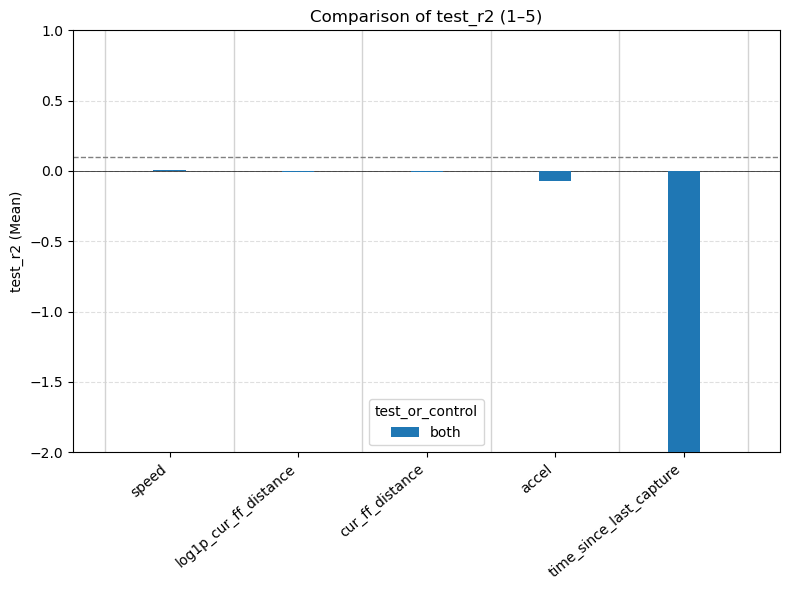

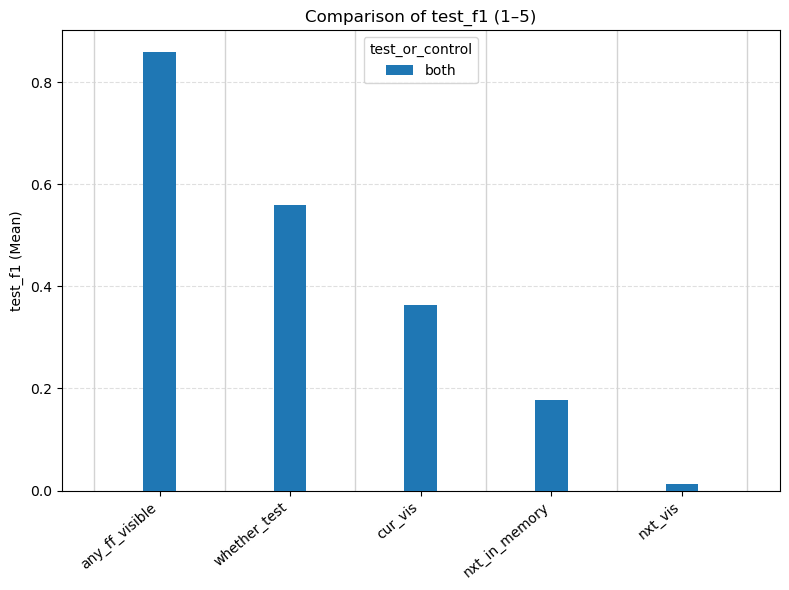

data_0228
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Retrieved ff_dataframe from all_monkey_data/processed_data/monkey_Bruno/data_0228/ff_dataframe.h5
Error processing data_0228: [Errno 2] No such file or directory: 'all_monkey_data/neural_data/monkey_Bruno/data_0228/Sorted/spike_times.npy'
data_0301
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Retrieved ff_dataframe from all_monkey_data/processed_data/monkey_Bruno/data_0301/ff_dataframe.h5
Made new binned_spikes_df and saved to all_monkey_data/processed_neural_data/monkey_Bruno/data_0301/binned_spikes_df_0p1.csv
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/null_behaviors/opt_arc_utils.py:432: RuntimeWarning: divide by zero encountered in divide
  all_arc_radius = ff_y_relative/np.sin(arc_angle)
/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/null_behaviors/curvature_utils.py:131: RuntimeWarning: invalid value encountered in add
  arc_end_x = np.cos(angle_from_center_to_stop)*arc_radius + center_x
/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/null_behaviors/curvature_utils.py:132: RuntimeWarning: invalid value encountered in add
  arc_end_y = np.sin(angle_from_center_to_stop)*arc_radius + center_y



NA Values Analysis for behav_data_by_bin (143,623 rows)

Number of rows with at least one NA value: 120,065

Columns with NA values:
------------------------------------------------------------
stop_id_duration                          104,874 (  73.0%)
stop_id_start_time                        104,874 (  73.0%)
stop_id_end_time                          104,874 (  73.0%)
stop_cluster_id                           104,874 (  73.0%)
stop_cluster_start_point                  104,874 (  73.0%)
stop_cluster_end_point                    104,874 (  73.0%)
stop_cluster_size                         104,874 (  73.0%)
time_since_target_last_seen                50,885 (  35.4%)
target_last_seen_distance                  50,885 (  35.4%)
time_target_last_seen                      50,885 (  35.4%)
target_last_seen_angle                     50,885 (  35.4%)
target_last_seen_angle_to_boundary         50,885 (  35.4%)
monkey_x_target_last_seen                  50,885 (  35.4%)
monkey_y_target_last_seen

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)
/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the g

x_var.shape: (6656, 20)
y_var.shape: (6656, 37)
x_var_reduced.shape: (6656, 20)
y_var_reduced.shape: (6656, 33)
x_var_lags.shape: (6656, 211)
y_var_lags.shape: (6656, 398)
new_seg_duration is now 1.0, and post_event_window is now 0.75
Dropped 162 out of 430 segments because of insufficient duration, which is 37.7% of all segments
Made new new_seg_info and saved to all_monkey_data/planning_and_neural/monkey_Bruno/data_0301/new_seg_info/tlim2_cur_first_pre0p25_post0p75.csv
Dropped 43 columns due to containing NA in rebinned_y_var via calling drop_na_cols function: ['nxt_cntr_arc_curv', 'nxt_opt_arc_curv', 'cur_opt_arc_curv', 'cur_cntr_arc_curv', 'cur_opt_arc_end_heading', 'angle_opt_cur_end_to_nxt_ff', 'angle_from_stop_to_nxt_ff', 'diff_in_angle_to_nxt_ff', 'diff_in_abs_angle_to_nxt_ff', 'traj_curv_to_stop', 'curv_from_stop_to_nxt_ff', 'opt_curv_to_cur_ff', 'curv_from_cur_end_to_nxt_ff', 'd_curv_null_arc', 'd_curv_monkey', 'abs_d_curv_null_arc', 'abs_d_curv_monkey', 'diff_in_d_curv', 'di

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)



No NA values found in concat_neural_trials

No NA values found in concat_behav_trials

No NA values found in concat_neural_trials

No NA values found in concat_behav_trials

=== Data Dimensions Summary ===
Total number of trials: 268

Concatenated Data Shapes (total n_timepoints × n_features):
  concat_neural_trials:     (2616, 74)
  concat_behav_trials:      (2616, 33)
test_or_control: both
x_var dimensions: (1822, 72)
y_var dimensions: (1822, 33)


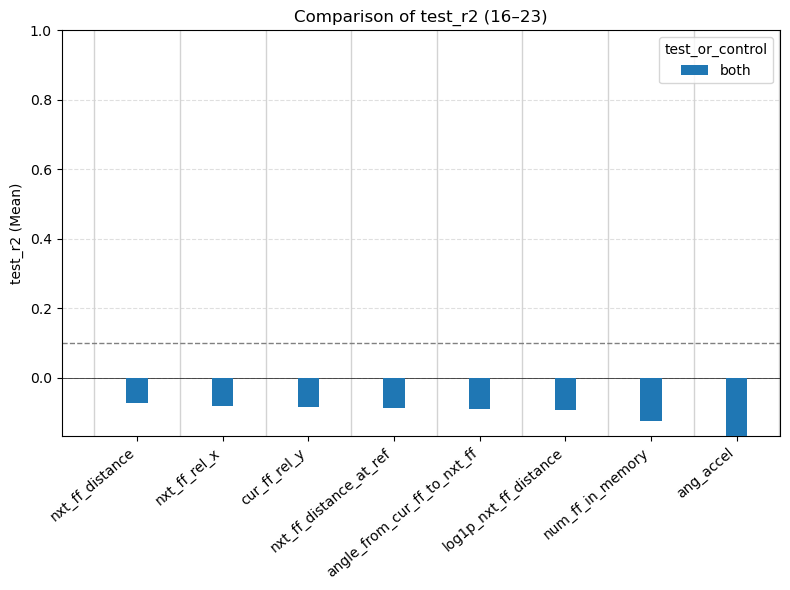

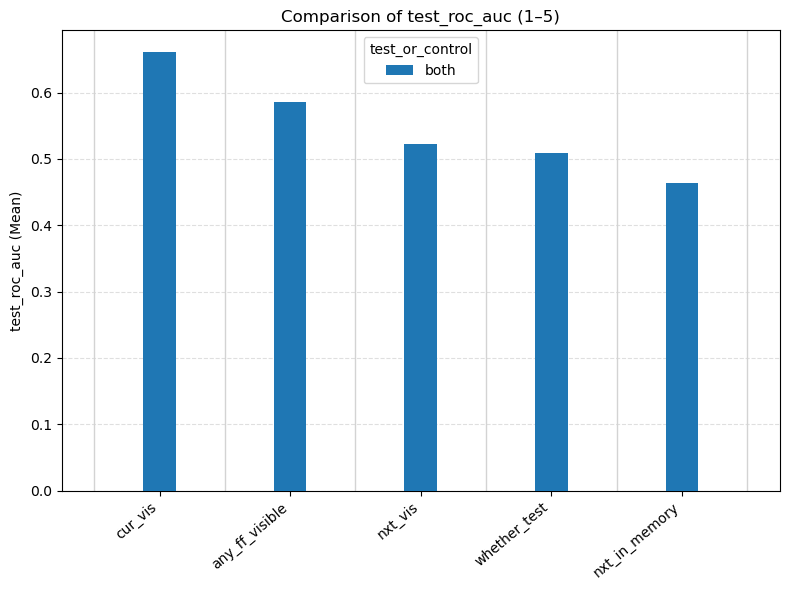

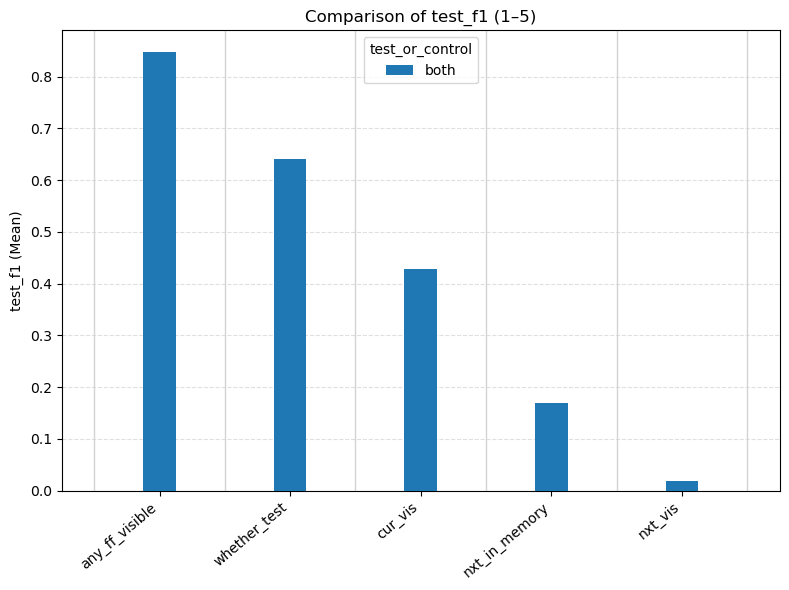

data_0306
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Retrieved ff_dataframe from all_monkey_data/processed_data/monkey_Bruno/data_0306/ff_dataframe.h5
Error processing data_0306: [Errno 2] No such file or directory: 'all_monkey_data/neural_data/monkey_Bruno/data_0306/Sorted/spike_times.npy'
data_0307
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Retrieved ff_dataframe from all_monkey_data/processed_data/monkey_Bruno/data_0307/ff_dataframe.h5
Made new binned_spikes_df and saved to all_monkey_data/processed_neural_data/monkey_Bruno/data_0307/binned_spikes_df_0p1.csv
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)
/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the g

Removing 12 columns with zero variance: ['cluster_6_0', 'cluster_6_-1', 'cluster_6_1', 'cluster_6_-2', 'cluster_6_2', 'cluster_6_-3', 'cluster_6_3', 'cluster_6_-4', 'cluster_6_4', 'cluster_6_-5', 'cluster_6_5', 'cluster_18_5']
x_var.shape: (8509, 22)
y_var.shape: (8509, 37)
x_var_reduced.shape: (8509, 21)
y_var_reduced.shape: (8509, 34)
x_var_lags.shape: (8509, 233)
y_var_lags.shape: (8509, 398)
new_seg_duration is now 1.0, and post_event_window is now 0.75
Dropped 232 out of 569 segments because of insufficient duration, which is 40.8% of all segments
Made new new_seg_info and saved to all_monkey_data/planning_and_neural/monkey_Bruno/data_0307/new_seg_info/tlim2_cur_first_pre0p25_post0p75.csv
Dropped 43 columns due to containing NA in rebinned_y_var via calling drop_na_cols function: ['nxt_cntr_arc_curv', 'nxt_opt_arc_curv', 'cur_opt_arc_curv', 'cur_cntr_arc_curv', 'cur_opt_arc_end_heading', 'angle_opt_cur_end_to_nxt_ff', 'angle_from_stop_to_nxt_ff', 'diff_in_angle_to_nxt_ff', 'diff_i

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)


Made rebinned_x_var, rebinned_y_var, rebinned_x_var_lags, and rebinned_y_var_lags.

No NA values found in concat_neural_trials

No NA values found in concat_behav_trials
Rank deficiency detected: 1 redundant neurons
Matrix shape: (337, 72), Rank: 71
Smallest singular values:
[0.      0.2784  0.56854 1.01081 1.19677]
Dropping redundant neuron: cluster_16_-2

No NA values found in concat_neural_trials

No NA values found in concat_behav_trials

=== Data Dimensions Summary ===
Total number of trials: 337

Concatenated Data Shapes (total n_timepoints × n_features):
  concat_neural_trials:     (3311, 73)
  concat_behav_trials:      (3311, 33)
test_or_control: both
x_var dimensions: (2308, 71)
y_var dimensions: (2308, 33)


/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

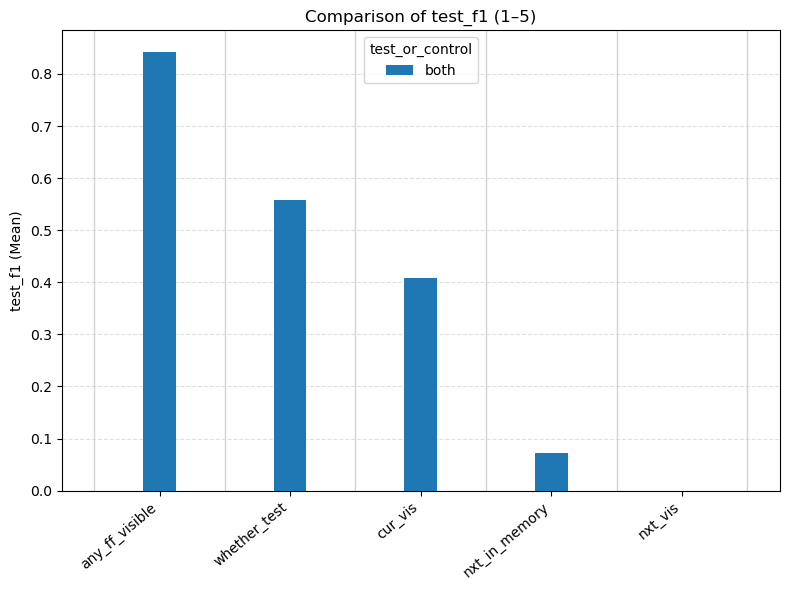

data_0308
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Retrieved ff_dataframe from all_monkey_data/processed_data/monkey_Bruno/data_0308/ff_dataframe.h5
Made new binned_spikes_df and saved to all_monkey_data/processed_neural_data/monkey_Bruno/data_0308/binned_spikes_df_0p1.csv
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Removed 0 rows out of 727 rows where cur_ff was not visible bbas or nxt_ff was not visible both bbas and bsans
shared_stops_near_ff_df has 727 rows
Retrieving shared_stops_near_ff_df succeeded
[Warning] 0.241% of ff_y_relative values are negative and will be removed.
[Warning] 6.763% of ff_x_relative > ff_y_relative. Rows will be removed.
Failed to retrieve heading_info_df because Failed to retrieve diff_in_curv_d

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)
/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the g

x_var.shape: (9885, 23)
y_var.shape: (9885, 37)
x_var_reduced.shape: (9885, 23)
y_var_reduced.shape: (9885, 33)
x_var_lags.shape: (9885, 244)
y_var_lags.shape: (9885, 398)
new_seg_duration is now 1.0, and post_event_window is now 0.75
Dropped 270 out of 632 segments because of insufficient duration, which is 42.7% of all segments
Made new new_seg_info and saved to all_monkey_data/planning_and_neural/monkey_Bruno/data_0308/new_seg_info/tlim2_cur_first_pre0p25_post0p75.csv
Dropped 43 columns due to containing NA in rebinned_y_var via calling drop_na_cols function: ['nxt_cntr_arc_curv', 'nxt_opt_arc_curv', 'cur_opt_arc_curv', 'cur_cntr_arc_curv', 'cur_opt_arc_end_heading', 'angle_opt_cur_end_to_nxt_ff', 'angle_from_stop_to_nxt_ff', 'diff_in_angle_to_nxt_ff', 'diff_in_abs_angle_to_nxt_ff', 'traj_curv_to_stop', 'curv_from_stop_to_nxt_ff', 'opt_curv_to_cur_ff', 'curv_from_cur_end_to_nxt_ff', 'd_curv_null_arc', 'd_curv_monkey', 'abs_d_curv_null_arc', 'abs_d_curv_monkey', 'diff_in_d_curv', 'di

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)


Made rebinned_x_var, rebinned_y_var, rebinned_x_var_lags, and rebinned_y_var_lags.

No NA values found in concat_neural_trials

No NA values found in concat_behav_trials
Rank deficiency detected: 3 redundant neurons
Matrix shape: (362, 84), Rank: 81
Smallest singular values:
[0.      0.      0.      0.4541  0.67719]
Dropping redundant neuron: cluster_20_-2
Rank deficiency detected: 2 redundant neurons
Matrix shape: (362, 83), Rank: 81
Smallest singular values:
[0.      0.      0.4541  0.67712 1.27748]
Dropping redundant neuron: cluster_20_-1
Rank deficiency detected: 1 redundant neurons
Matrix shape: (362, 82), Rank: 81
Smallest singular values:
[0.      0.45408 0.60723 1.27676 1.71233]
Dropping redundant neuron: cluster_13_-2

No NA values found in concat_neural_trials

No NA values found in concat_behav_trials

=== Data Dimensions Summary ===
Total number of trials: 362

Concatenated Data Shapes (total n_timepoints × n_features):
  concat_neural_trials:     (3562, 83)
  concat_behav_

/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

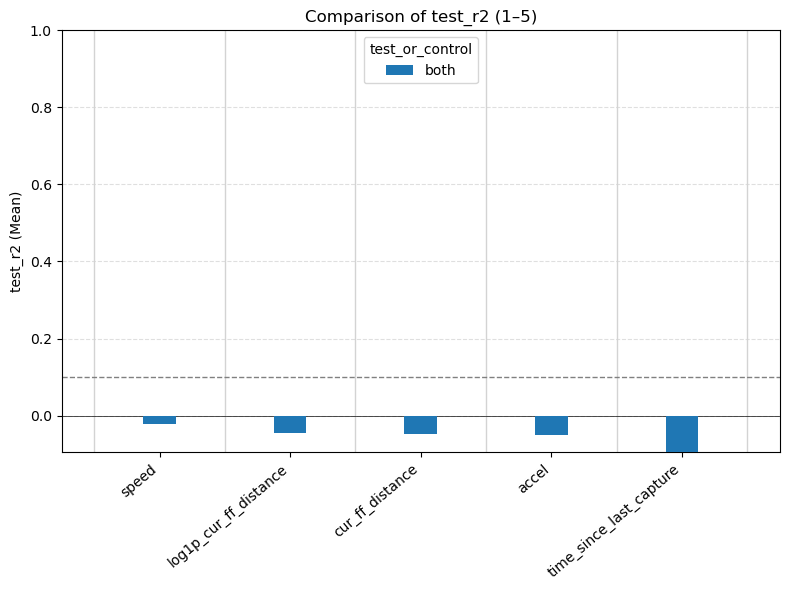

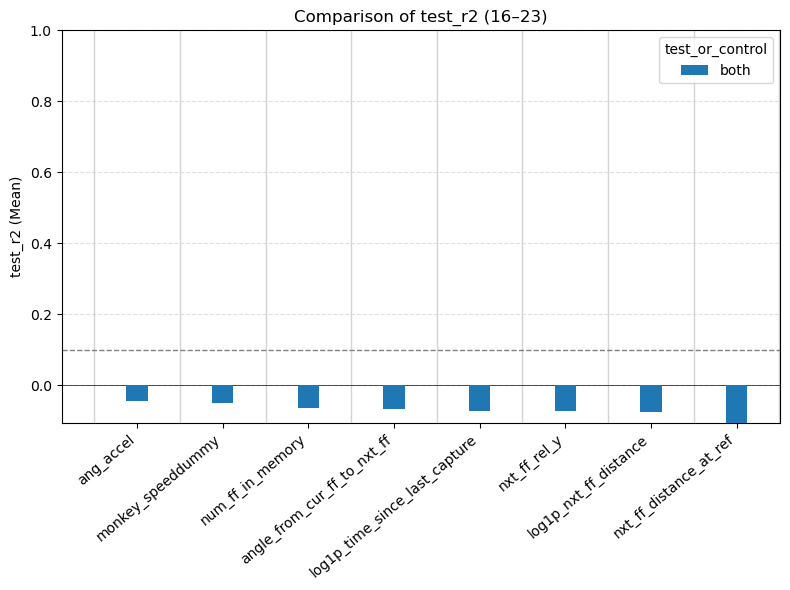

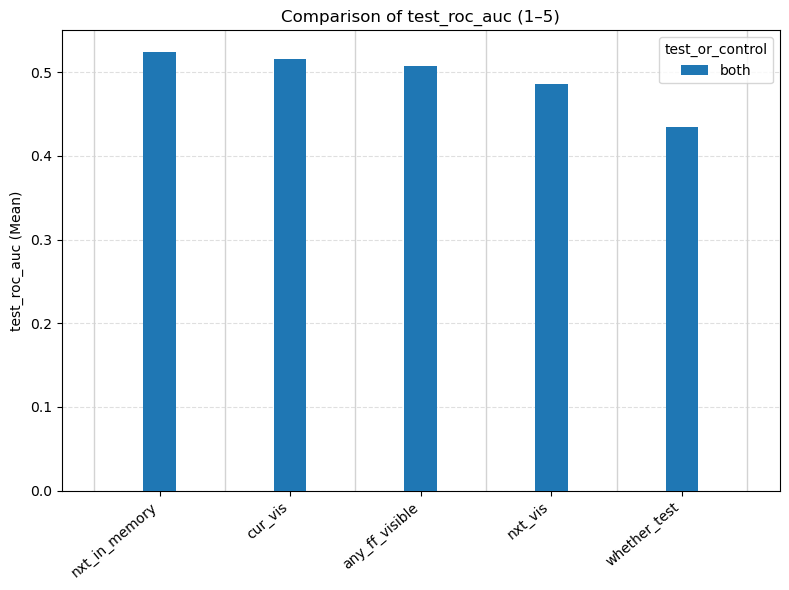

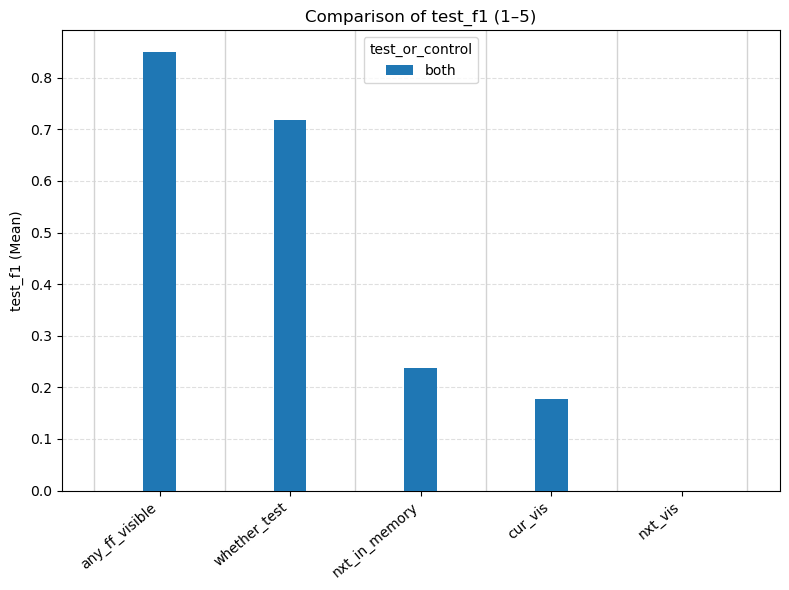

data_0309
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Retrieved ff_dataframe from all_monkey_data/processed_data/monkey_Bruno/data_0309/ff_dataframe.h5
Made new binned_spikes_df and saved to all_monkey_data/processed_neural_data/monkey_Bruno/data_0309/binned_spikes_df_0p1.csv
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Removed 0 rows out of 575 rows where cur_ff was not visible bbas or nxt_ff was not visible both bbas and bsans
shared_stops_near_ff_df has 575 rows
Retrieving shared_stops_near_ff_df succeeded
[Warning] 0.323% of ff_y_relative values are negative and will be removed.
[Warning] 7.767% of ff_x_relative > ff_y_relative. Rows will be removed.
Failed to retrieve heading_info_df because Failed to retrieve diff_in_curv_d

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)
/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the g

x_var.shape: (7737, 31)
y_var.shape: (7737, 37)
x_var_reduced.shape: (7737, 31)
y_var_reduced.shape: (7737, 33)
x_var_lags.shape: (7737, 332)
y_var_lags.shape: (7737, 398)
new_seg_duration is now 1.0, and post_event_window is now 0.75
Dropped 200 out of 496 segments because of insufficient duration, which is 40.3% of all segments
Made new new_seg_info and saved to all_monkey_data/planning_and_neural/monkey_Bruno/data_0309/new_seg_info/tlim2_cur_first_pre0p25_post0p75.csv
Dropped 43 columns due to containing NA in rebinned_y_var via calling drop_na_cols function: ['nxt_cntr_arc_curv', 'nxt_opt_arc_curv', 'cur_opt_arc_curv', 'cur_cntr_arc_curv', 'cur_opt_arc_end_heading', 'angle_opt_cur_end_to_nxt_ff', 'angle_from_stop_to_nxt_ff', 'diff_in_angle_to_nxt_ff', 'diff_in_abs_angle_to_nxt_ff', 'traj_curv_to_stop', 'curv_from_stop_to_nxt_ff', 'opt_curv_to_cur_ff', 'curv_from_cur_end_to_nxt_ff', 'd_curv_null_arc', 'd_curv_monkey', 'abs_d_curv_null_arc', 'abs_d_curv_monkey', 'diff_in_d_curv', 'di

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)



No NA values found in concat_neural_trials

No NA values found in concat_behav_trials
Rank deficiency detected: 5 redundant neurons
Matrix shape: (296, 116), Rank: 111
Smallest singular values:
[0. 0. 0. 0. 0.]
Dropping redundant neuron: cluster_3_-2
Rank deficiency detected: 4 redundant neurons
Matrix shape: (296, 115), Rank: 111
Smallest singular values:
[0.      0.      0.      0.      0.35046]
Dropping redundant neuron: cluster_6_-2
Rank deficiency detected: 3 redundant neurons
Matrix shape: (296, 114), Rank: 111
Smallest singular values:
[0.      0.      0.      0.35046 0.50309]
Dropping redundant neuron: cluster_3_0
Rank deficiency detected: 2 redundant neurons
Matrix shape: (296, 113), Rank: 111
Smallest singular values:
[0.      0.      0.35046 0.50308 0.75344]
Dropping redundant neuron: cluster_3_-1
Rank deficiency detected: 1 redundant neurons
Matrix shape: (296, 112), Rank: 111
Smallest singular values:
[0.      0.35046 0.50307 0.75344 0.94908]
Dropping redundant neuron: cl

/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


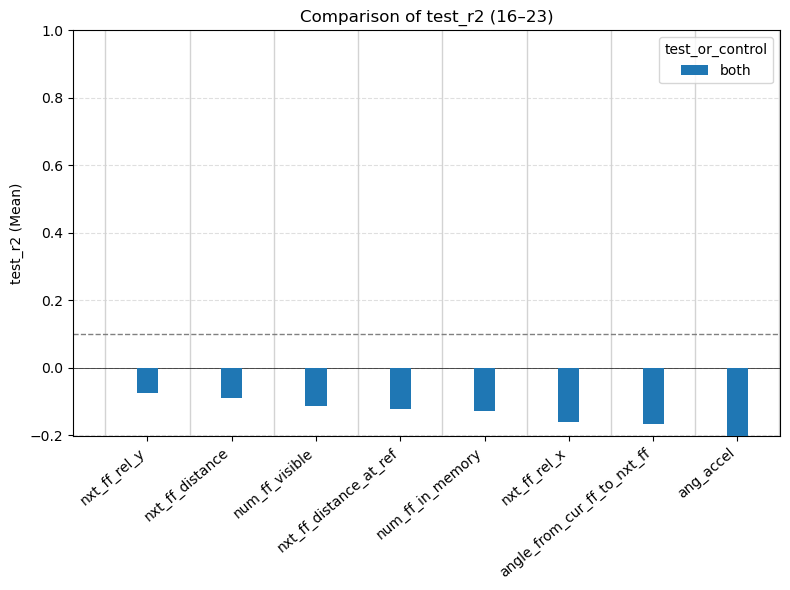

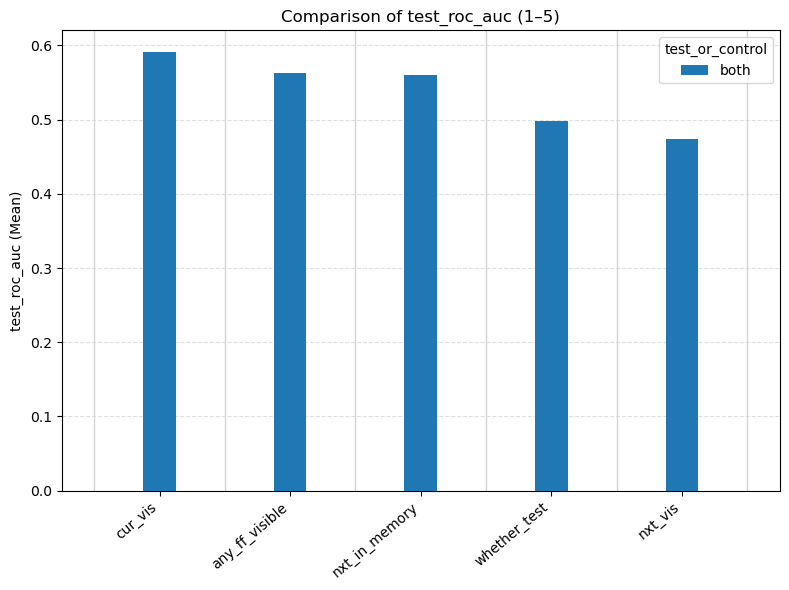

data_0312
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Retrieved ff_dataframe from all_monkey_data/processed_data/monkey_Bruno/data_0312/ff_dataframe.h5
Made new binned_spikes_df and saved to all_monkey_data/processed_neural_data/monkey_Bruno/data_0312/binned_spikes_df_0p1.csv
Loaded planning_data_by_point from all_monkey_data/planning_and_neural/monkey_Bruno/data_0312/planning_data_by_point/opt_arc_stop_closest/test/cur_vis_0_1_window_-25cm_0cm
Loaded planning_data_by_point from all_monkey_data/planning_and_neural/monkey_Bruno/data_0312/planning_data_by_point/opt_arc_stop_closest/control/cur_vis_0_1_window_-25cm_0cm
Loaded behav_data_by_bin from all_monkey_data/target_decoder/monkey_Bruno/data_0312/behav_data_by_point.csv
There are 1 duplicated point_index in bin_info. Note: one_point_index_per_bin is False
Dropped 7 columns with more than 50.0% missing val

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)
/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the g

x_var.shape: (6166, 27)
y_var.shape: (6166, 37)
x_var_reduced.shape: (6166, 27)
y_var_reduced.shape: (6166, 33)
x_var_lags.shape: (6166, 288)
y_var_lags.shape: (6166, 398)
new_seg_duration is now 1.0, and post_event_window is now 0.75
Dropped 192 out of 408 segments because of insufficient duration, which is 47.1% of all segments
Made new new_seg_info and saved to all_monkey_data/planning_and_neural/monkey_Bruno/data_0312/new_seg_info/tlim2_cur_first_pre0p25_post0p75.csv
Dropped 43 columns due to containing NA in rebinned_y_var via calling drop_na_cols function: ['nxt_cntr_arc_curv', 'cur_opt_arc_curv', 'cur_cntr_arc_curv', 'nxt_opt_arc_curv', 'cur_opt_arc_end_heading', 'angle_opt_cur_end_to_nxt_ff', 'angle_from_stop_to_nxt_ff', 'diff_in_angle_to_nxt_ff', 'diff_in_abs_angle_to_nxt_ff', 'traj_curv_to_stop', 'curv_from_stop_to_nxt_ff', 'opt_curv_to_cur_ff', 'curv_from_cur_end_to_nxt_ff', 'd_curv_null_arc', 'd_curv_monkey', 'abs_d_curv_null_arc', 'abs_d_curv_monkey', 'diff_in_d_curv', 'di

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)



No NA values found in concat_neural_trials

No NA values found in concat_behav_trials
Rank deficiency detected: 4 redundant neurons
Matrix shape: (216, 100), Rank: 96
Smallest singular values:
[0.      0.      0.      0.      0.18339]
Dropping redundant neuron: cluster_13_-3
Rank deficiency detected: 3 redundant neurons
Matrix shape: (216, 99), Rank: 96
Smallest singular values:
[0.      0.      0.      0.17921 0.24811]
Dropping redundant neuron: cluster_8_-2
Rank deficiency detected: 2 redundant neurons
Matrix shape: (216, 98), Rank: 96
Smallest singular values:
[0.      0.      0.17921 0.24809 0.48498]
Dropping redundant neuron: cluster_8_-1
Rank deficiency detected: 1 redundant neurons
Matrix shape: (216, 97), Rank: 96
Smallest singular values:
[0.      0.1792  0.24807 0.48481 0.53101]
Dropping redundant neuron: cluster_3_-1

No NA values found in concat_neural_trials

No NA values found in concat_behav_trials

=== Data Dimensions Summary ===
Total number of trials: 216

Concatenat

/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


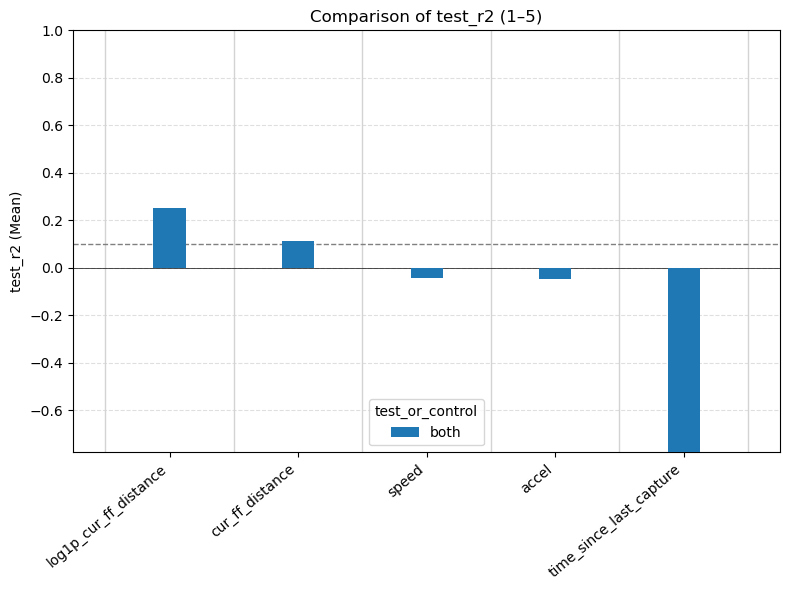

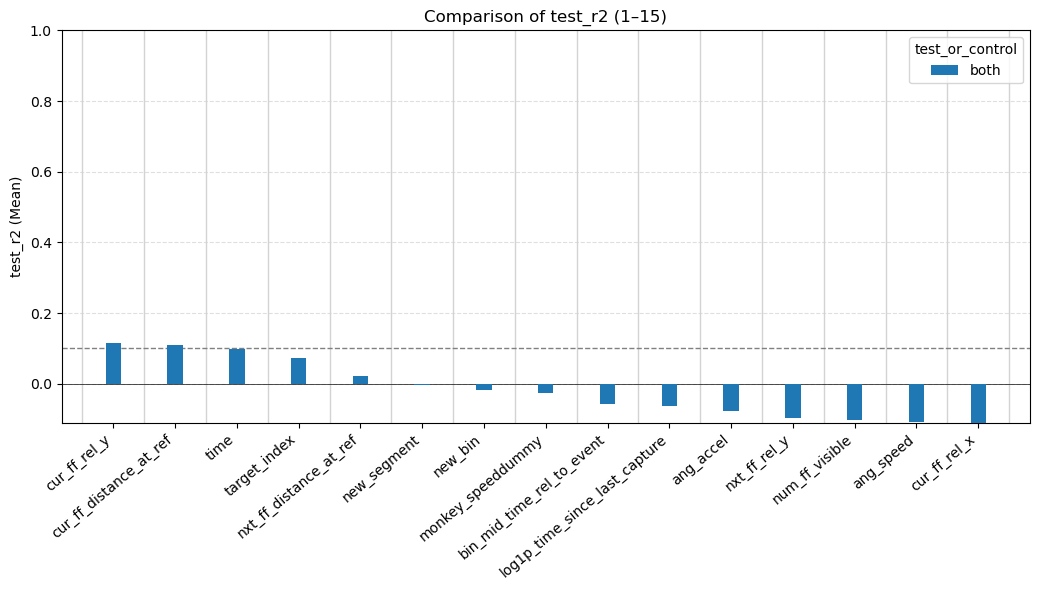

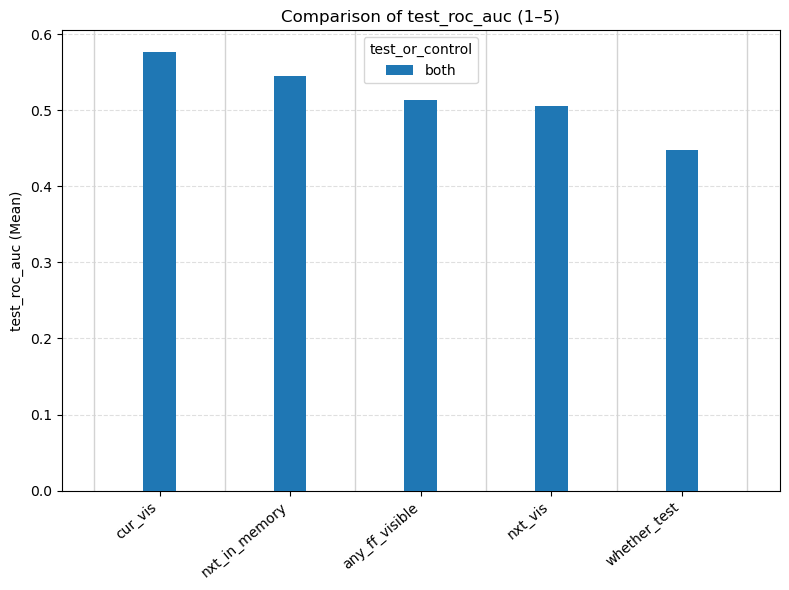

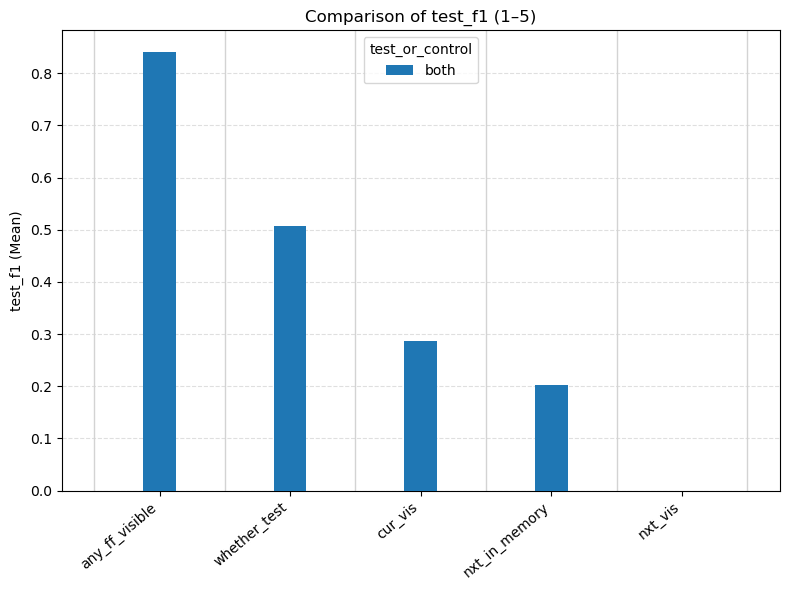

data_0314
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Retrieved ff_dataframe from all_monkey_data/processed_data/monkey_Bruno/data_0314/ff_dataframe.h5
Made new binned_spikes_df and saved to all_monkey_data/processed_neural_data/monkey_Bruno/data_0314/binned_spikes_df_0p1.csv
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Removed 0 rows out of 585 rows where cur_ff was not visible bbas or nxt_ff was not visible both bbas and bsans
shared_stops_near_ff_df has 585 rows
Retrieving shared_stops_near_ff_df succeeded
[Warning] 6.863% of ff_x_relative > ff_y_relative. Rows will be removed.
Failed to retrieve heading_info_df because Failed to retrieve diff_in_curv_df: cur_vis_0_1_window_-25cm_0cm is not in the folder: all_monkey_data/plann

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)
/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the g

x_var.shape: (7899, 26)
y_var.shape: (7899, 37)
x_var_reduced.shape: (7899, 26)
y_var_reduced.shape: (7899, 33)
x_var_lags.shape: (7899, 277)
y_var_lags.shape: (7899, 398)
new_seg_duration is now 1.0, and post_event_window is now 0.75
Dropped 199 out of 508 segments because of insufficient duration, which is 39.2% of all segments
Made new new_seg_info and saved to all_monkey_data/planning_and_neural/monkey_Bruno/data_0314/new_seg_info/tlim2_cur_first_pre0p25_post0p75.csv
Dropped 43 columns due to containing NA in rebinned_y_var via calling drop_na_cols function: ['nxt_cntr_arc_curv', 'nxt_opt_arc_curv', 'cur_opt_arc_curv', 'cur_cntr_arc_curv', 'cur_opt_arc_end_heading', 'angle_opt_cur_end_to_nxt_ff', 'angle_from_stop_to_nxt_ff', 'diff_in_angle_to_nxt_ff', 'diff_in_abs_angle_to_nxt_ff', 'traj_curv_to_stop', 'curv_from_stop_to_nxt_ff', 'opt_curv_to_cur_ff', 'curv_from_cur_end_to_nxt_ff', 'd_curv_null_arc', 'd_curv_monkey', 'abs_d_curv_null_arc', 'abs_d_curv_monkey', 'diff_in_d_curv', 'di

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)



No NA values found in concat_neural_trials

No NA values found in concat_behav_trials
Rank deficiency detected: 1 redundant neurons
Matrix shape: (309, 92), Rank: 91
Smallest singular values:
[0.      0.18539 0.41411 0.43286 1.35479]
Dropping redundant neuron: cluster_21_-2

No NA values found in concat_neural_trials

No NA values found in concat_behav_trials

=== Data Dimensions Summary ===
Total number of trials: 309

Concatenated Data Shapes (total n_timepoints × n_features):
  concat_neural_trials:     (3040, 93)
  concat_behav_trials:      (3040, 33)
test_or_control: both
x_var dimensions: (2131, 91)
y_var dimensions: (2131, 33)


/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


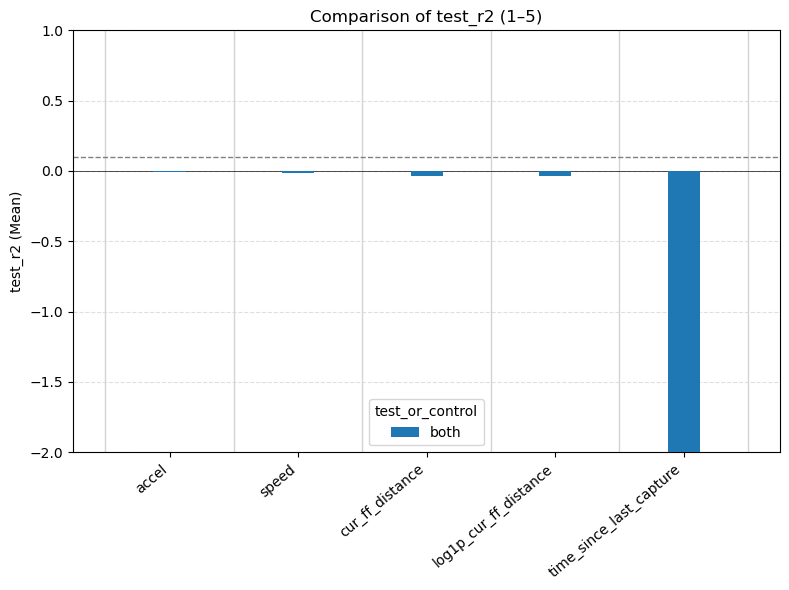

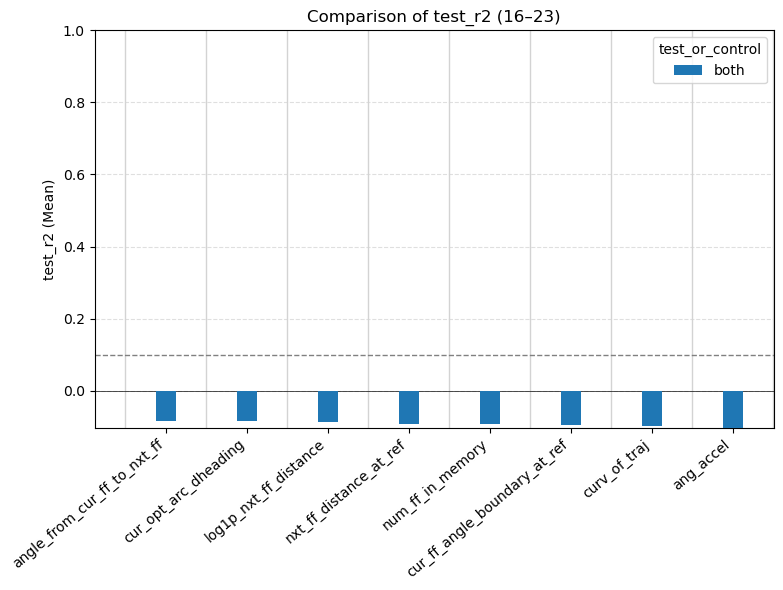

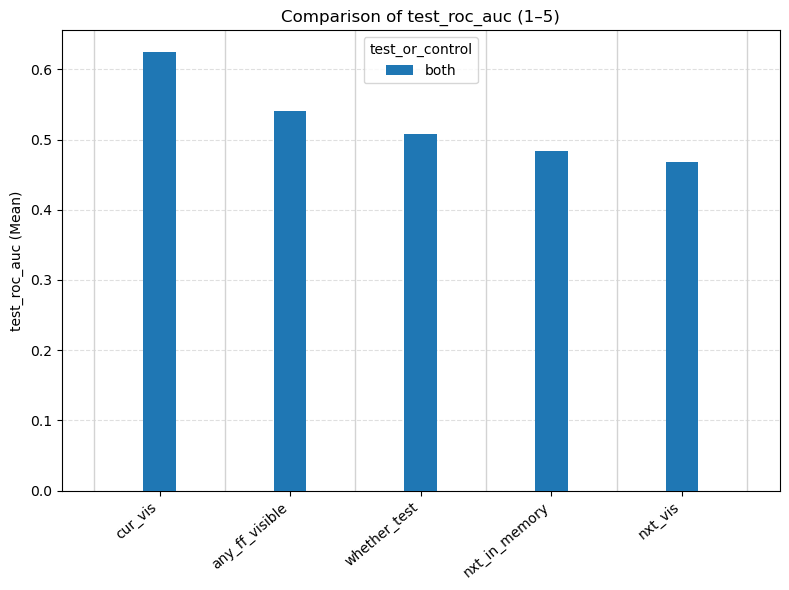

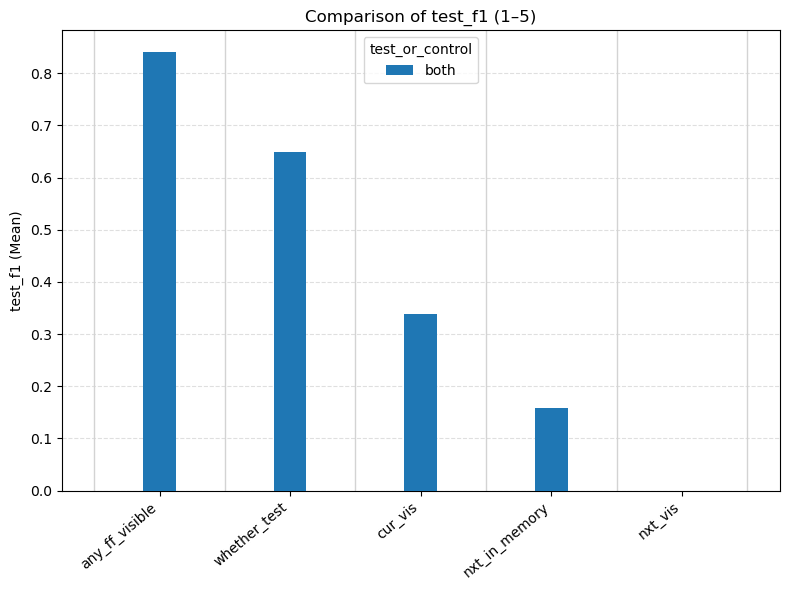

data_0315
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Retrieved ff_dataframe from all_monkey_data/processed_data/monkey_Bruno/data_0315/ff_dataframe.h5
Made new binned_spikes_df and saved to all_monkey_data/processed_neural_data/monkey_Bruno/data_0315/binned_spikes_df_0p1.csv
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Removed 0 rows out of 563 rows where cur_ff was not visible bbas or nxt_ff was not visible both bbas and bsans
shared_stops_near_ff_df has 563 rows
Retrieving shared_stops_near_ff_df succeeded
[Warning] 7.000% of ff_x_relative > ff_y_relative. Rows will be removed.
[Warning] 0.362% of ff_x_relative > ff_y_relative. Rows will be removed.
Failed to retrieve heading_info_df because Failed to retrieve diff_in_curv_df:

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)
/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the g

x_var.shape: (7746, 5)
y_var.shape: (7746, 37)
x_var_reduced.shape: (7746, 5)
y_var_reduced.shape: (7746, 33)
x_var_lags.shape: (7746, 46)
y_var_lags.shape: (7746, 398)
new_seg_duration is now 1.0, and post_event_window is now 0.75
Dropped 211 out of 486 segments because of insufficient duration, which is 43.4% of all segments
Made new new_seg_info and saved to all_monkey_data/planning_and_neural/monkey_Bruno/data_0315/new_seg_info/tlim2_cur_first_pre0p25_post0p75.csv
Dropped 43 columns due to containing NA in rebinned_y_var via calling drop_na_cols function: ['nxt_cntr_arc_curv', 'nxt_opt_arc_curv', 'cur_opt_arc_curv', 'cur_cntr_arc_curv', 'cur_opt_arc_end_heading', 'angle_opt_cur_end_to_nxt_ff', 'angle_from_stop_to_nxt_ff', 'diff_in_angle_to_nxt_ff', 'diff_in_abs_angle_to_nxt_ff', 'traj_curv_to_stop', 'curv_from_stop_to_nxt_ff', 'opt_curv_to_cur_ff', 'curv_from_cur_end_to_nxt_ff', 'd_curv_null_arc', 'd_curv_monkey', 'abs_d_curv_null_arc', 'abs_d_curv_monkey', 'diff_in_d_curv', 'diff_

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)



No NA values found in concat_neural_trials

No NA values found in concat_behav_trials

No NA values found in concat_neural_trials

No NA values found in concat_behav_trials

=== Data Dimensions Summary ===
Total number of trials: 275

Concatenated Data Shapes (total n_timepoints × n_features):
  concat_neural_trials:     (2713, 14)
  concat_behav_trials:      (2713, 33)
test_or_control: both
x_var dimensions: (1895, 12)
y_var dimensions: (1895, 33)


/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

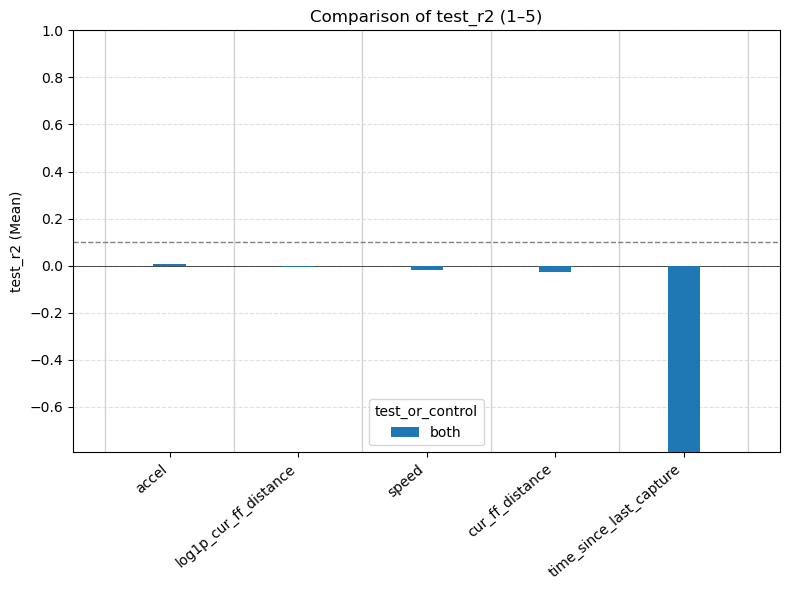

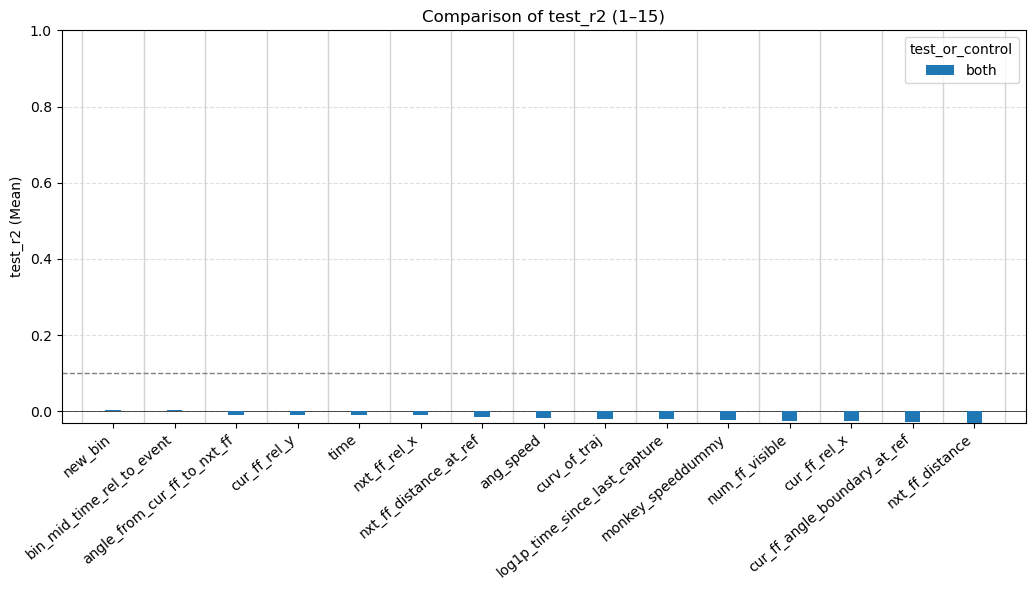

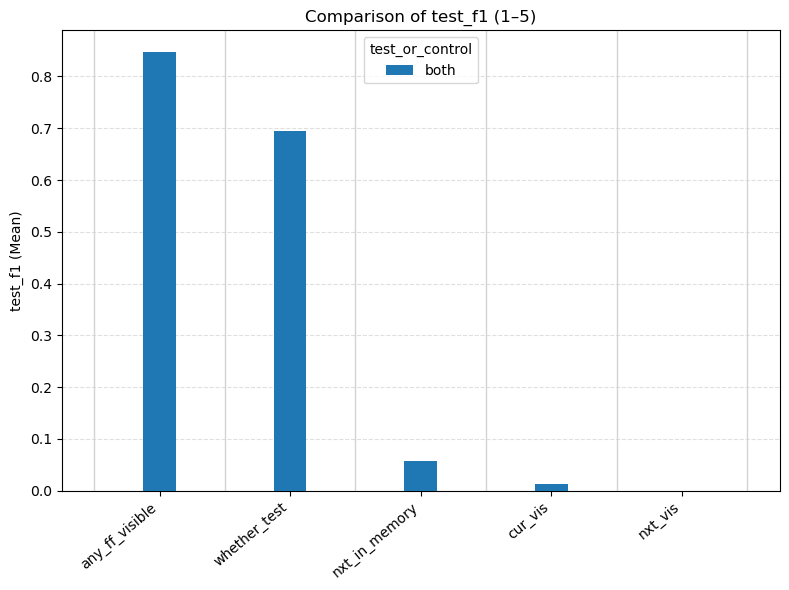

data_0316
Loaded binned_spikes_df from all_monkey_data/processed_neural_data/monkey_Bruno/data_0316/binned_spikes_df_0p1.csv
Loaded planning_data_by_point from all_monkey_data/planning_and_neural/monkey_Bruno/data_0316/planning_data_by_point/opt_arc_stop_closest/test/cur_vis_0_1_window_-25cm_0cm
Loaded planning_data_by_point from all_monkey_data/planning_and_neural/monkey_Bruno/data_0316/planning_data_by_point/opt_arc_stop_closest/control/cur_vis_0_1_window_-25cm_0cm
Loaded behav_data_by_bin from all_monkey_data/target_decoder/monkey_Bruno/data_0316/behav_data_by_point.csv
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Dropped 7 columns with more than 50.0% missing values: ['stop_id_duration', 'stop_cluster_size', 'stop_id_start_time', 'stop_cluster_start_point', 'stop_cluster_id', 'stop_cluster_end_point', 'stop_id_end_time']
0.23% of rows are dropped in plan

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)
/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the g

x_var.shape: (10066, 24)
y_var.shape: (10066, 37)
x_var_reduced.shape: (10066, 24)
y_var_reduced.shape: (10066, 34)
x_var_lags.shape: (10066, 255)
y_var_lags.shape: (10066, 398)
new_seg_duration is now 1.0, and post_event_window is now 0.75
Loaded new_seg_info from all_monkey_data/planning_and_neural/monkey_Bruno/data_0316/new_seg_info/tlim2_cur_first_pre0p25_post0p75.csv
Dropped 43 columns due to containing NA in rebinned_y_var via calling drop_na_cols function: ['cur_cntr_arc_curv', 'cur_opt_arc_curv', 'nxt_opt_arc_curv', 'nxt_cntr_arc_curv', 'cur_opt_arc_end_heading', 'angle_opt_cur_end_to_nxt_ff', 'angle_from_stop_to_nxt_ff', 'diff_in_angle_to_nxt_ff', 'diff_in_abs_angle_to_nxt_ff', 'traj_curv_to_stop', 'curv_from_stop_to_nxt_ff', 'opt_curv_to_cur_ff', 'curv_from_cur_end_to_nxt_ff', 'd_curv_null_arc', 'd_curv_monkey', 'abs_d_curv_null_arc', 'abs_d_curv_monkey', 'diff_in_d_curv', 'diff_in_abs_d_curv', 'abs_angle_opt_cur_end_to_nxt_ff', 'abs_angle_from_stop_to_nxt_ff', 'abs_diff_in_a

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)


Made rebinned_x_var, rebinned_y_var, rebinned_x_var_lags, and rebinned_y_var_lags.

No NA values found in concat_neural_trials

No NA values found in concat_behav_trials
Rank deficiency detected: 1 redundant neurons
Matrix shape: (377, 88), Rank: 87
Smallest singular values:
[0.      0.49064 0.72571 0.9342  1.42936]
Dropping redundant neuron: cluster_20_-3

No NA values found in concat_neural_trials

No NA values found in concat_behav_trials

=== Data Dimensions Summary ===
Total number of trials: 377

Concatenated Data Shapes (total n_timepoints × n_features):
  concat_neural_trials:     (3714, 89)
  concat_behav_trials:      (3714, 33)
test_or_control: both
x_var dimensions: (2598, 87)
y_var dimensions: (2598, 33)


/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

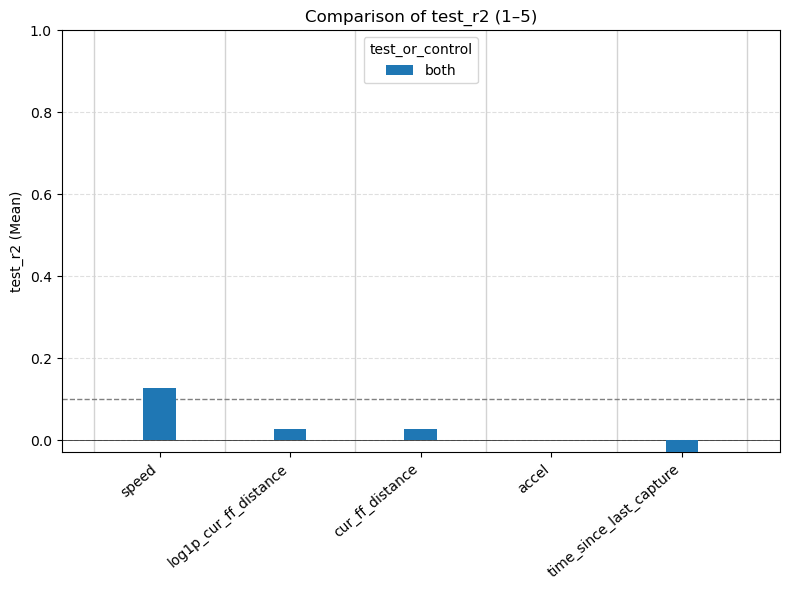

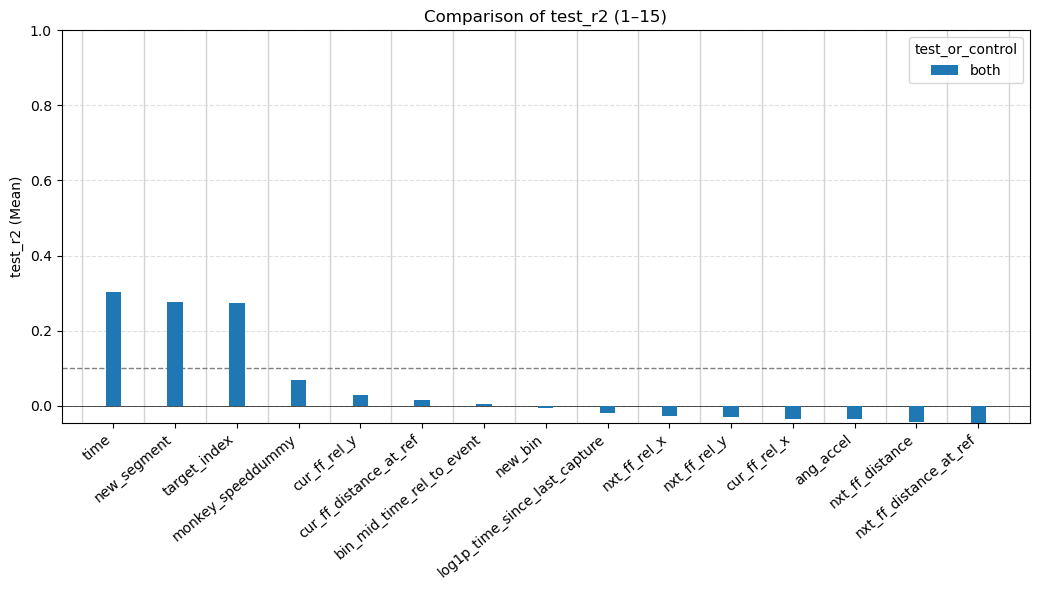

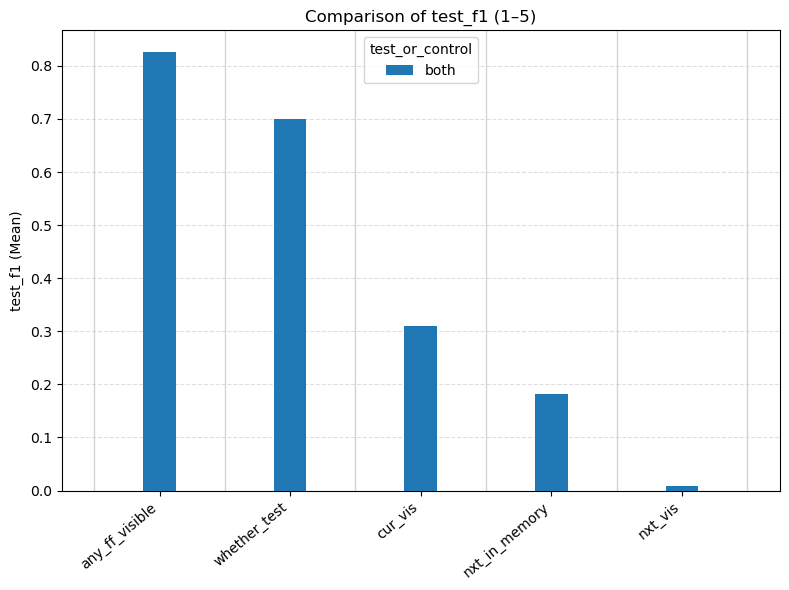

data_0321
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Retrieved ff_dataframe from all_monkey_data/processed_data/monkey_Bruno/data_0321/ff_dataframe.h5
Made new binned_spikes_df and saved to all_monkey_data/processed_neural_data/monkey_Bruno/data_0321/binned_spikes_df_0p1.csv
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Removed 0 rows out of 746 rows where cur_ff was not visible bbas or nxt_ff was not visible both bbas and bsans
shared_stops_near_ff_df has 746 rows
Retrieving shared_stops_near_ff_df succeeded
[Warning] 6.596% of ff_x_relative > ff_y_relative. Rows will be removed.
Failed to retrieve heading_info_df because Failed to retrieve diff_in_curv_df: cur_vis_0_1_window_-25cm_0cm is not in the folder: all_monkey_data/plann

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)
/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the g

x_var.shape: (9394, 21)
y_var.shape: (9394, 37)
x_var_reduced.shape: (9394, 21)
y_var_reduced.shape: (9394, 33)
x_var_lags.shape: (9394, 222)
y_var_lags.shape: (9394, 398)
new_seg_duration is now 1.0, and post_event_window is now 0.75
Dropped 272 out of 630 segments because of insufficient duration, which is 43.2% of all segments
Made new new_seg_info and saved to all_monkey_data/planning_and_neural/monkey_Bruno/data_0321/new_seg_info/tlim2_cur_first_pre0p25_post0p75.csv
Dropped 43 columns due to containing NA in rebinned_y_var via calling drop_na_cols function: ['nxt_cntr_arc_curv', 'nxt_opt_arc_curv', 'cur_opt_arc_curv', 'cur_cntr_arc_curv', 'cur_opt_arc_end_heading', 'angle_opt_cur_end_to_nxt_ff', 'angle_from_stop_to_nxt_ff', 'diff_in_angle_to_nxt_ff', 'diff_in_abs_angle_to_nxt_ff', 'traj_curv_to_stop', 'curv_from_stop_to_nxt_ff', 'opt_curv_to_cur_ff', 'curv_from_cur_end_to_nxt_ff', 'd_curv_null_arc', 'd_curv_monkey', 'abs_d_curv_null_arc', 'abs_d_curv_monkey', 'diff_in_d_curv', 'di

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)


Made rebinned_x_var, rebinned_y_var, rebinned_x_var_lags, and rebinned_y_var_lags.

No NA values found in concat_neural_trials

No NA values found in concat_behav_trials
Rank deficiency detected: 2 redundant neurons
Matrix shape: (358, 72), Rank: 70
Smallest singular values:
[0.      0.      0.4691  0.50116 0.70579]
Dropping redundant neuron: cluster_7_-2
Rank deficiency detected: 1 redundant neurons
Matrix shape: (358, 71), Rank: 70
Smallest singular values:
[0.      0.46902 0.50109 0.59995 0.71026]
Dropping redundant neuron: cluster_8_-2

No NA values found in concat_neural_trials

No NA values found in concat_behav_trials

=== Data Dimensions Summary ===
Total number of trials: 358

Concatenated Data Shapes (total n_timepoints × n_features):
  concat_neural_trials:     (3532, 72)
  concat_behav_trials:      (3532, 33)
test_or_control: both
x_var dimensions: (2468, 70)
y_var dimensions: (2468, 33)


/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


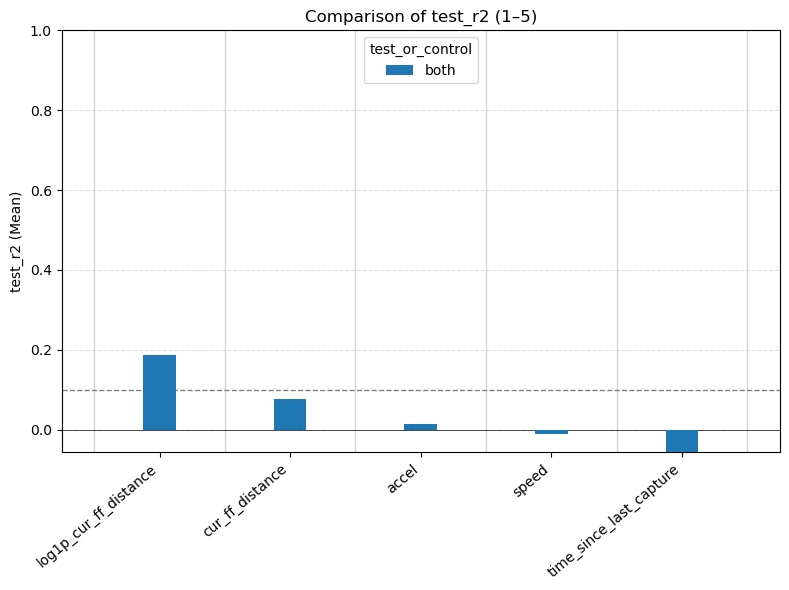

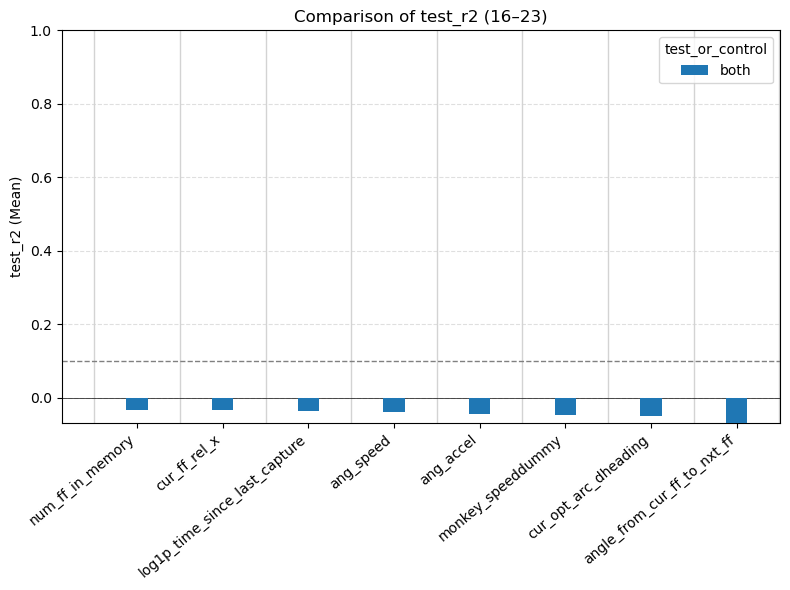

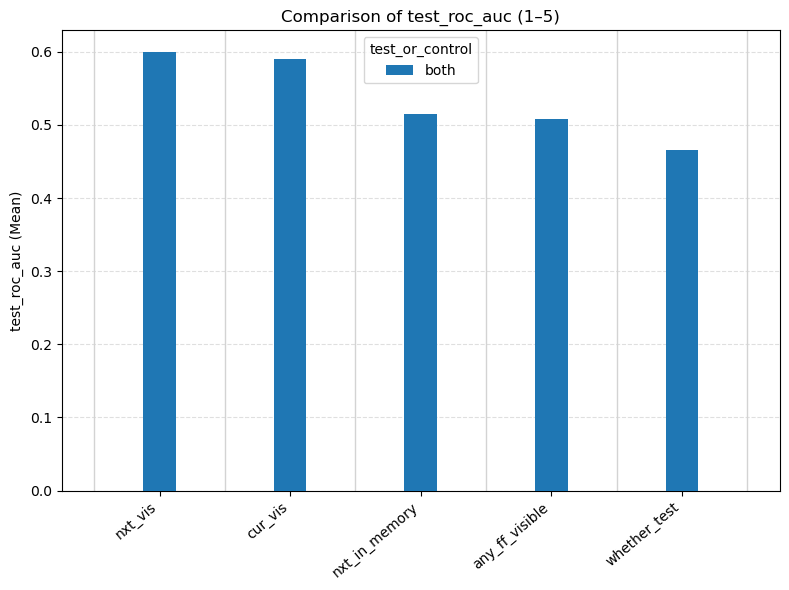

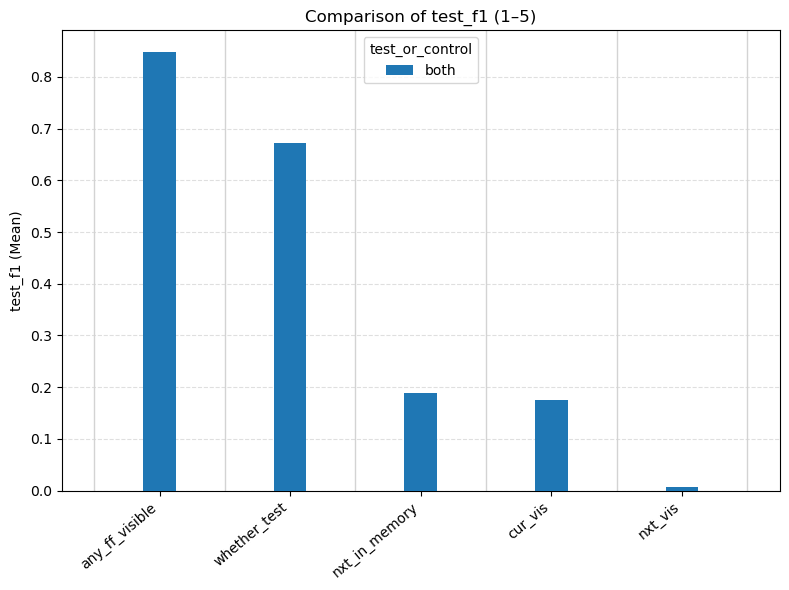

data_0322
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Retrieved ff_dataframe from all_monkey_data/processed_data/monkey_Bruno/data_0322/ff_dataframe.h5
Error processing data_0322: [Errno 2] No such file or directory: 'all_monkey_data/neural_data/monkey_Bruno/data_0322/Sorted/spike_times.npy'
data_0323
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Retrieved ff_dataframe from all_monkey_data/processed_data/monkey_Bruno/data_0323/ff_dataframe.h5
Made new binned_spikes_df and saved to all_monkey_data/processed_neural_data/monkey_Bruno/data_0323/binned_spikes_df_0p1.csv
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)
/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the g

x_var.shape: (8304, 14)
y_var.shape: (8304, 37)
x_var_reduced.shape: (8304, 14)
y_var_reduced.shape: (8304, 34)
x_var_lags.shape: (8304, 145)
y_var_lags.shape: (8304, 398)
new_seg_duration is now 1.0, and post_event_window is now 0.75
Dropped 231 out of 531 segments because of insufficient duration, which is 43.5% of all segments
Made new new_seg_info and saved to all_monkey_data/planning_and_neural/monkey_Bruno/data_0323/new_seg_info/tlim2_cur_first_pre0p25_post0p75.csv
Dropped 43 columns due to containing NA in rebinned_y_var via calling drop_na_cols function: ['nxt_cntr_arc_curv', 'nxt_opt_arc_curv', 'cur_opt_arc_curv', 'cur_cntr_arc_curv', 'cur_opt_arc_end_heading', 'angle_opt_cur_end_to_nxt_ff', 'angle_from_stop_to_nxt_ff', 'diff_in_angle_to_nxt_ff', 'diff_in_abs_angle_to_nxt_ff', 'traj_curv_to_stop', 'curv_from_stop_to_nxt_ff', 'opt_curv_to_cur_ff', 'curv_from_cur_end_to_nxt_ff', 'd_curv_null_arc', 'd_curv_monkey', 'abs_d_curv_null_arc', 'abs_d_curv_monkey', 'diff_in_d_curv', 'di

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)



No NA values found in concat_neural_trials

No NA values found in concat_behav_trials

No NA values found in concat_neural_trials

No NA values found in concat_behav_trials

=== Data Dimensions Summary ===
Total number of trials: 300

Concatenated Data Shapes (total n_timepoints × n_features):
  concat_neural_trials:     (2939, 50)
  concat_behav_trials:      (2939, 33)
test_or_control: both
x_var dimensions: (2048, 48)
y_var dimensions: (2048, 33)


/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

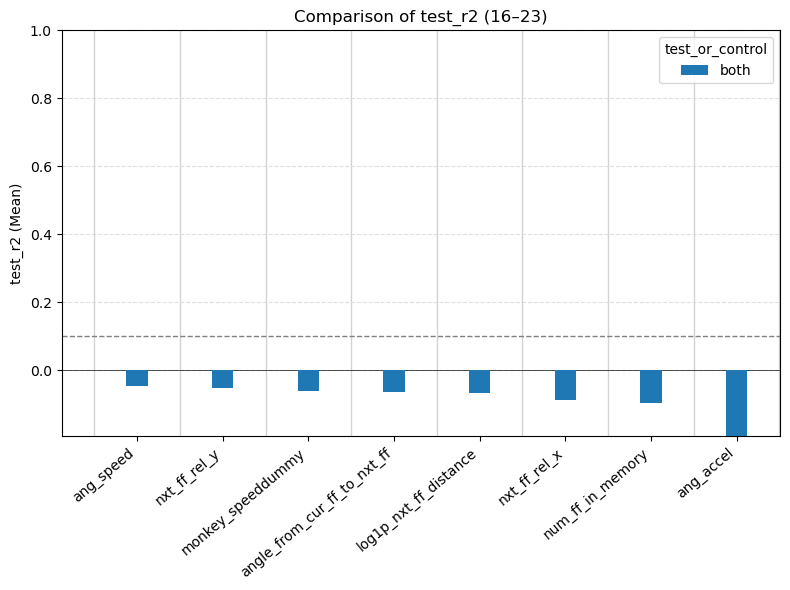

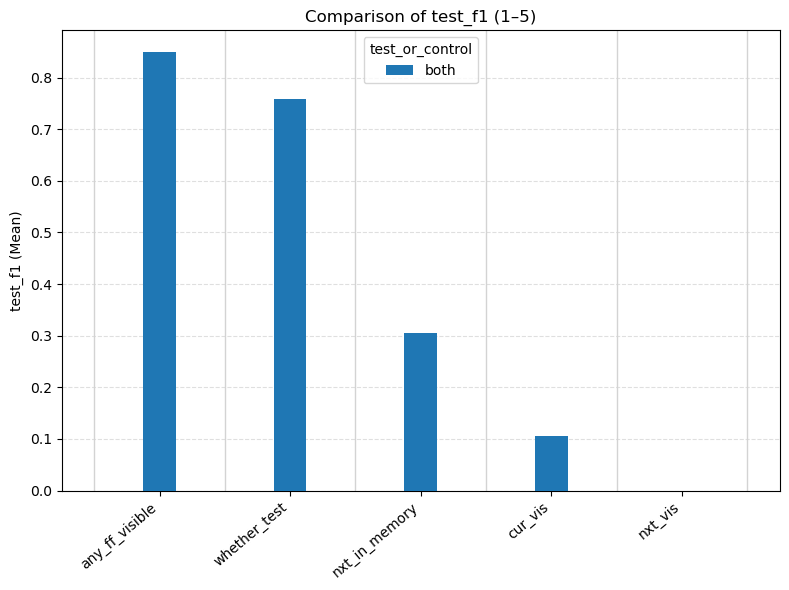

data_0326
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Retrieved ff_dataframe from all_monkey_data/processed_data/monkey_Bruno/data_0326/ff_dataframe.h5
Made new binned_spikes_df and saved to all_monkey_data/processed_neural_data/monkey_Bruno/data_0326/binned_spikes_df_0p1.csv
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Removed 0 rows out of 580 rows where cur_ff was not visible bbas or nxt_ff was not visible both bbas and bsans
shared_stops_near_ff_df has 580 rows
Retrieving shared_stops_near_ff_df succeeded
[Warning] 0.323% of ff_y_relative values are negative and will be removed.
[Warning] 5.178% of ff_x_relative > ff_y_relative. Rows will be removed.
Failed to retrieve heading_info_df because Failed to retrieve diff_in_curv_d

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)
/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the g

x_var.shape: (7019, 30)
y_var.shape: (7019, 37)
x_var_reduced.shape: (7019, 30)
y_var_reduced.shape: (7019, 32)
x_var_lags.shape: (7019, 321)
y_var_lags.shape: (7019, 398)
new_seg_duration is now 1.0, and post_event_window is now 0.75
Dropped 227 out of 484 segments because of insufficient duration, which is 46.9% of all segments
Made new new_seg_info and saved to all_monkey_data/planning_and_neural/monkey_Bruno/data_0326/new_seg_info/tlim2_cur_first_pre0p25_post0p75.csv
Dropped 43 columns due to containing NA in rebinned_y_var via calling drop_na_cols function: ['nxt_cntr_arc_curv', 'nxt_opt_arc_curv', 'cur_opt_arc_curv', 'cur_cntr_arc_curv', 'cur_opt_arc_end_heading', 'angle_opt_cur_end_to_nxt_ff', 'angle_from_stop_to_nxt_ff', 'diff_in_angle_to_nxt_ff', 'diff_in_abs_angle_to_nxt_ff', 'traj_curv_to_stop', 'curv_from_stop_to_nxt_ff', 'opt_curv_to_cur_ff', 'curv_from_cur_end_to_nxt_ff', 'd_curv_null_arc', 'd_curv_monkey', 'abs_d_curv_null_arc', 'abs_d_curv_monkey', 'diff_in_d_curv', 'di

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)



No NA values found in concat_neural_trials

No NA values found in concat_behav_trials
Rank deficiency detected: 6 redundant neurons
Matrix shape: (257, 112), Rank: 106
Smallest singular values:
[0. 0. 0. 0. 0.]
Dropping redundant neuron: cluster_0_-2
Rank deficiency detected: 5 redundant neurons
Matrix shape: (257, 111), Rank: 106
Smallest singular values:
[0. 0. 0. 0. 0.]
Dropping redundant neuron: cluster_25_-1
Rank deficiency detected: 4 redundant neurons
Matrix shape: (257, 110), Rank: 106
Smallest singular values:
[0.      0.      0.      0.      0.09292]
Dropping redundant neuron: cluster_25_-2
Rank deficiency detected: 3 redundant neurons
Matrix shape: (257, 109), Rank: 106
Smallest singular values:
[0.      0.      0.      0.08595 0.19704]
Dropping redundant neuron: cluster_24_-1
Rank deficiency detected: 2 redundant neurons
Matrix shape: (257, 108), Rank: 106
Smallest singular values:
[0.      0.      0.08593 0.19669 0.34092]
Dropping redundant neuron: cluster_24_-2
Rank defi

/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


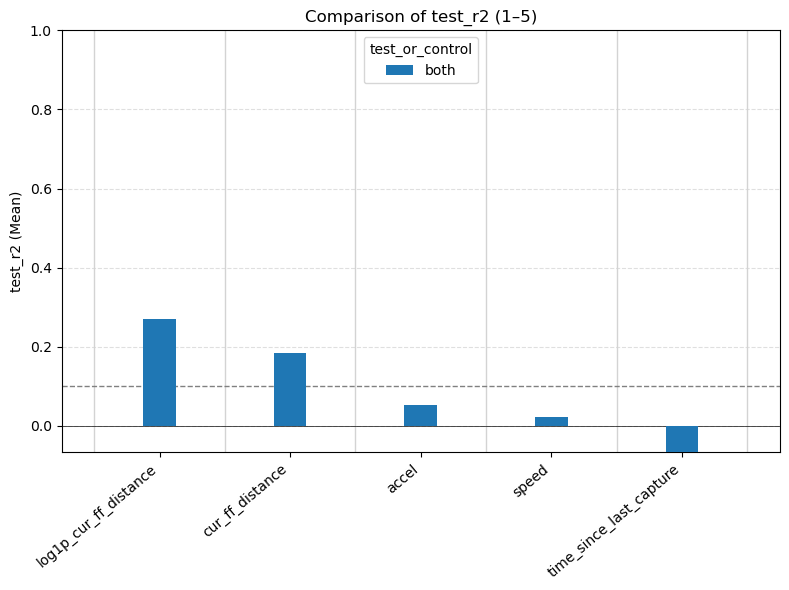

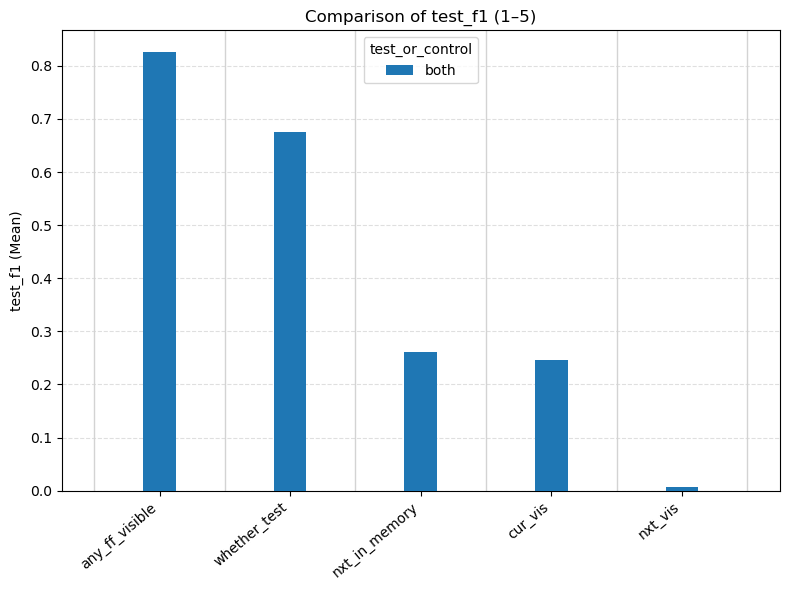

data_0327
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Retrieved ff_dataframe from all_monkey_data/processed_data/monkey_Bruno/data_0327/ff_dataframe.h5
Made new binned_spikes_df and saved to all_monkey_data/processed_neural_data/monkey_Bruno/data_0327/binned_spikes_df_0p1.csv
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Removed 0 rows out of 650 rows where cur_ff was not visible bbas or nxt_ff was not visible both bbas and bsans
shared_stops_near_ff_df has 650 rows
Retrieving shared_stops_near_ff_df succeeded
[Warning] 4.167% of ff_x_relative > ff_y_relative. Rows will be removed.
Failed to retrieve heading_info_df because Failed to retrieve diff_in_curv_df: cur_vis_0_1_window_-25cm_0cm is not in the folder: all_monkey_data/plann

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)
/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the g

x_var.shape: (8647, 32)
y_var.shape: (8647, 37)
x_var_reduced.shape: (8647, 32)
y_var_reduced.shape: (8647, 33)
x_var_lags.shape: (8647, 343)
y_var_lags.shape: (8647, 398)
new_seg_duration is now 1.0, and post_event_window is now 0.75
Dropped 209 out of 553 segments because of insufficient duration, which is 37.8% of all segments
Made new new_seg_info and saved to all_monkey_data/planning_and_neural/monkey_Bruno/data_0327/new_seg_info/tlim2_cur_first_pre0p25_post0p75.csv
Dropped 43 columns due to containing NA in rebinned_y_var via calling drop_na_cols function: ['nxt_cntr_arc_curv', 'nxt_opt_arc_curv', 'cur_opt_arc_curv', 'cur_cntr_arc_curv', 'cur_opt_arc_end_heading', 'angle_opt_cur_end_to_nxt_ff', 'angle_from_stop_to_nxt_ff', 'diff_in_angle_to_nxt_ff', 'diff_in_abs_angle_to_nxt_ff', 'traj_curv_to_stop', 'curv_from_stop_to_nxt_ff', 'opt_curv_to_cur_ff', 'curv_from_cur_end_to_nxt_ff', 'd_curv_null_arc', 'd_curv_monkey', 'abs_d_curv_null_arc', 'abs_d_curv_monkey', 'diff_in_d_curv', 'di

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)


Made rebinned_x_var, rebinned_y_var, rebinned_x_var_lags, and rebinned_y_var_lags.

No NA values found in concat_neural_trials

No NA values found in concat_behav_trials
Rank deficiency detected: 2 redundant neurons
Matrix shape: (344, 120), Rank: 118
Smallest singular values:
[0.      0.      0.30891 0.35798 0.74943]
Dropping redundant neuron: cluster_21_-2
Rank deficiency detected: 1 redundant neurons
Matrix shape: (344, 119), Rank: 118
Smallest singular values:
[0.      0.30887 0.35128 0.74943 1.01769]
Dropping redundant neuron: cluster_2_0

No NA values found in concat_neural_trials

No NA values found in concat_behav_trials

=== Data Dimensions Summary ===
Total number of trials: 344

Concatenated Data Shapes (total n_timepoints × n_features):
  concat_neural_trials:     (3376, 120)
  concat_behav_trials:      (3376, 33)
test_or_control: both
x_var dimensions: (2353, 118)
y_var dimensions: (2353, 33)


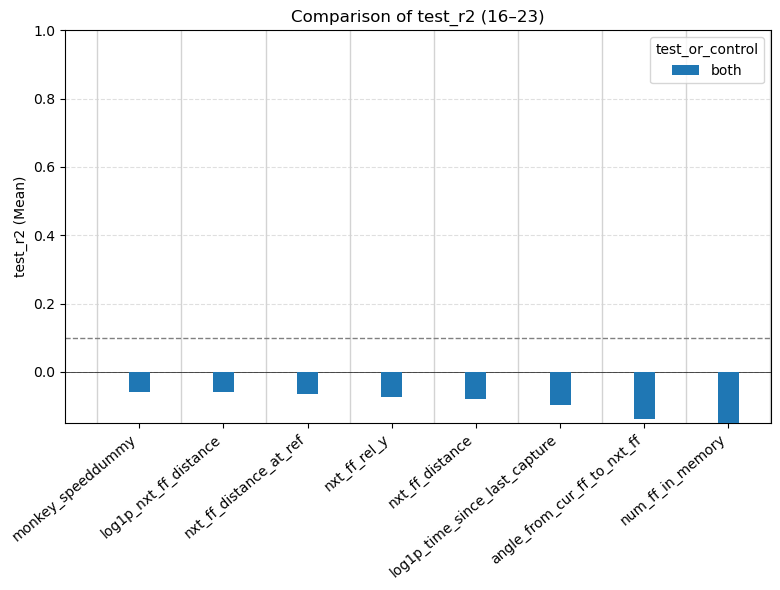

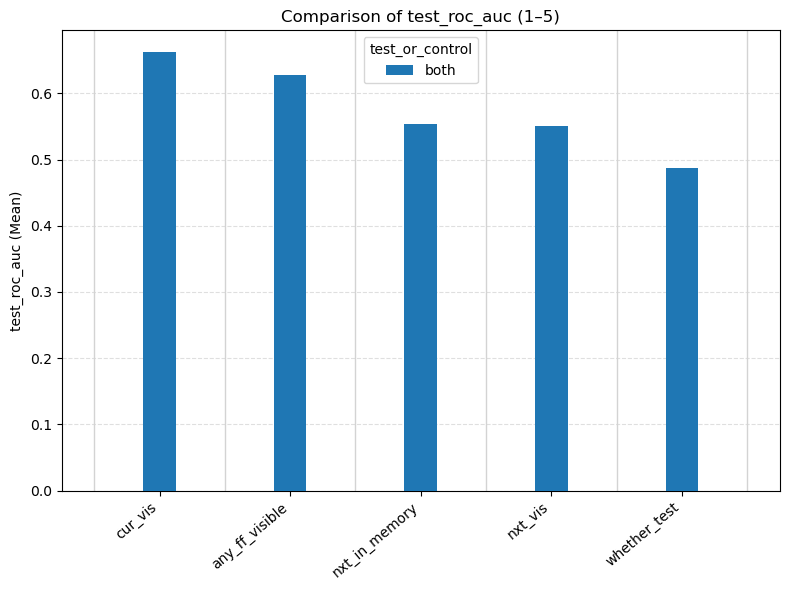

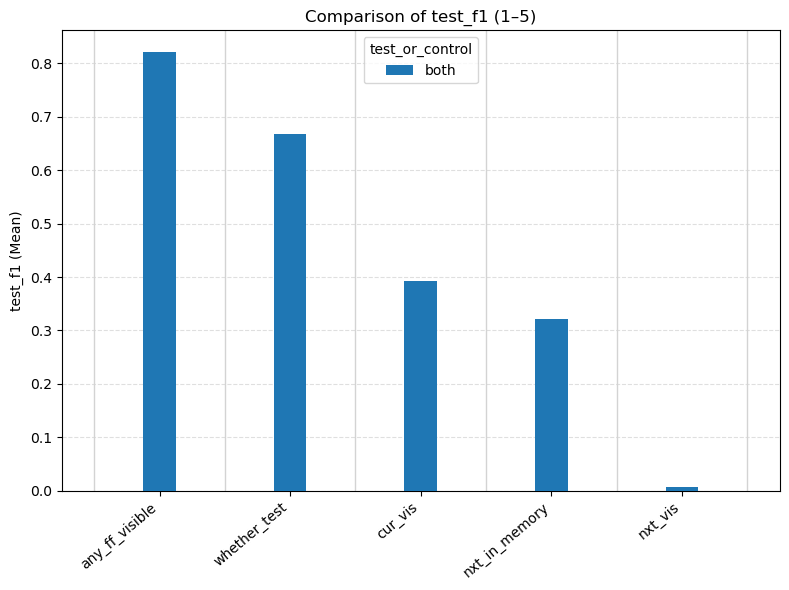

data_0328
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Retrieved ff_dataframe from all_monkey_data/processed_data/monkey_Bruno/data_0328/ff_dataframe.h5
Made new binned_spikes_df and saved to all_monkey_data/processed_neural_data/monkey_Bruno/data_0328/binned_spikes_df_0p1.csv
Loaded planning_data_by_point from all_monkey_data/planning_and_neural/monkey_Bruno/data_0328/planning_data_by_point/opt_arc_stop_closest/test/cur_vis_0_1_window_-25cm_0cm
Loaded planning_data_by_point from all_monkey_data/planning_and_neural/monkey_Bruno/data_0328/planning_data_by_point/opt_arc_stop_closest/control/cur_vis_0_1_window_-25cm_0cm
Loaded behav_data_by_bin from all_monkey_data/target_decoder/monkey_Bruno/data_0328/behav_data_by_point.csv
Dropped 7 columns with more than 50.0% missing values: ['stop_id_duration', 'stop_cluster_size', 'stop_id_start_time', 'stop_cluster_star

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)
/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the g

x_var.shape: (8712, 24)
y_var.shape: (8712, 37)
x_var_reduced.shape: (8712, 24)
y_var_reduced.shape: (8712, 33)
x_var_lags.shape: (8712, 255)
y_var_lags.shape: (8712, 398)
new_seg_duration is now 1.0, and post_event_window is now 0.75
Dropped 289 out of 619 segments because of insufficient duration, which is 46.7% of all segments
Made new new_seg_info and saved to all_monkey_data/planning_and_neural/monkey_Bruno/data_0328/new_seg_info/tlim2_cur_first_pre0p25_post0p75.csv
Dropped 43 columns due to containing NA in rebinned_y_var via calling drop_na_cols function: ['cur_opt_arc_curv', 'cur_cntr_arc_curv', 'nxt_cntr_arc_curv', 'nxt_opt_arc_curv', 'cur_opt_arc_end_heading', 'angle_opt_cur_end_to_nxt_ff', 'angle_from_stop_to_nxt_ff', 'diff_in_angle_to_nxt_ff', 'diff_in_abs_angle_to_nxt_ff', 'traj_curv_to_stop', 'curv_from_stop_to_nxt_ff', 'opt_curv_to_cur_ff', 'curv_from_cur_end_to_nxt_ff', 'd_curv_null_arc', 'd_curv_monkey', 'abs_d_curv_null_arc', 'abs_d_curv_monkey', 'diff_in_d_curv', 'di

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)


Made rebinned_x_var, rebinned_y_var, rebinned_x_var_lags, and rebinned_y_var_lags.

No NA values found in concat_neural_trials

No NA values found in concat_behav_trials
Rank deficiency detected: 5 redundant neurons
Matrix shape: (330, 88), Rank: 83
Smallest singular values:
[0. 0. 0. 0. 0.]
Dropping redundant neuron: cluster_16_-3
Rank deficiency detected: 4 redundant neurons
Matrix shape: (330, 87), Rank: 83
Smallest singular values:
[0.      0.      0.      0.      0.17914]
Dropping redundant neuron: cluster_15_-1
Rank deficiency detected: 3 redundant neurons
Matrix shape: (330, 86), Rank: 83
Smallest singular values:
[0.      0.      0.      0.17914 0.21008]
Dropping redundant neuron: cluster_16_-1
Rank deficiency detected: 2 redundant neurons
Matrix shape: (330, 85), Rank: 83
Smallest singular values:
[0.      0.      0.17914 0.21008 0.28852]
Dropping redundant neuron: cluster_16_0
Rank deficiency detected: 1 redundant neurons
Matrix shape: (330, 84), Rank: 83
Smallest singular va

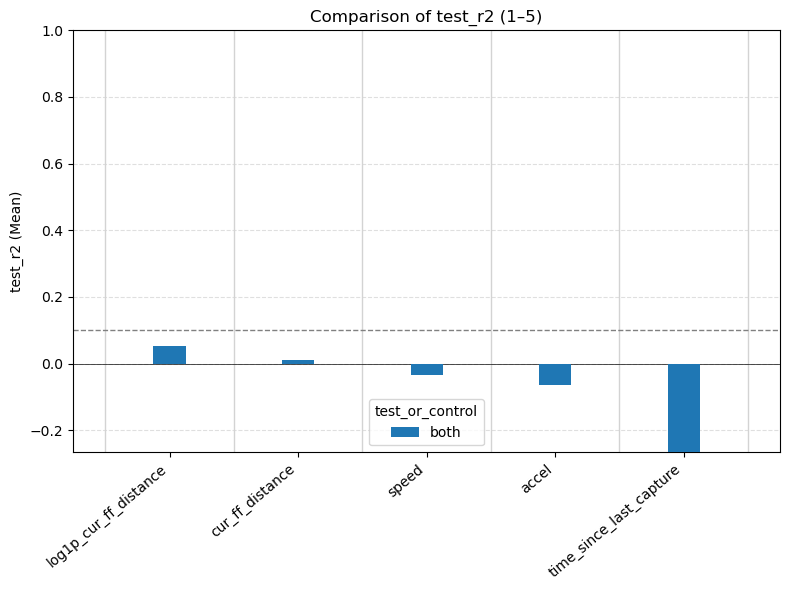

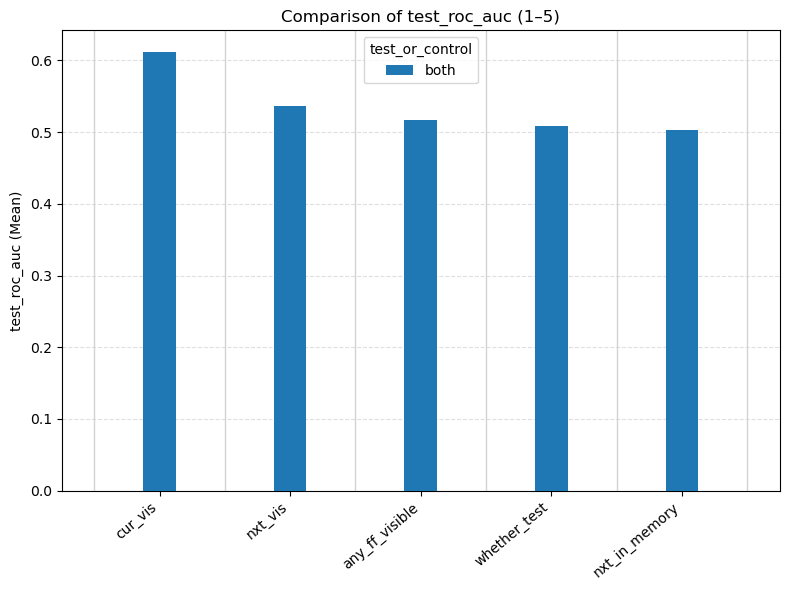

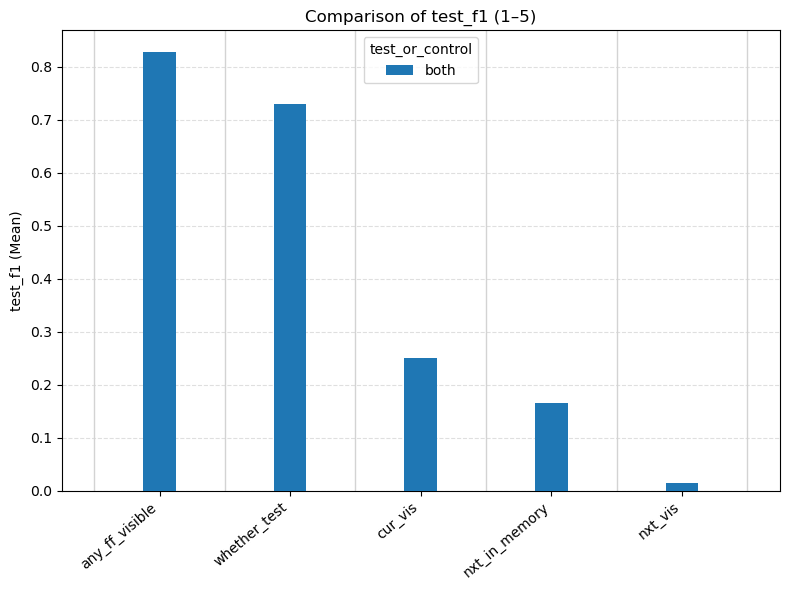

data_0329
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Retrieved ff_dataframe from all_monkey_data/processed_data/monkey_Bruno/data_0329/ff_dataframe.h5
Made new binned_spikes_df and saved to all_monkey_data/processed_neural_data/monkey_Bruno/data_0329/binned_spikes_df_0p1.csv
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Removed 0 rows out of 823 rows where cur_ff was not visible bbas or nxt_ff was not visible both bbas and bsans
shared_stops_near_ff_df has 823 rows
Retrieving shared_stops_near_ff_df succeeded
[Warning] 5.963% of ff_x_relative > ff_y_relative. Rows will be removed.
Failed to retrieve heading_info_df because Failed to retrieve diff_in_curv_df: cur_vis_0_1_window_-25cm_0cm is not in the folder: all_monkey_data/plann

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)
/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the g

x_var.shape: (10773, 22)
y_var.shape: (10773, 37)
x_var_reduced.shape: (10773, 22)
y_var_reduced.shape: (10773, 33)
x_var_lags.shape: (10773, 233)
y_var_lags.shape: (10773, 398)
new_seg_duration is now 1.0, and post_event_window is now 0.75
Dropped 336 out of 721 segments because of insufficient duration, which is 46.6% of all segments
Made new new_seg_info and saved to all_monkey_data/planning_and_neural/monkey_Bruno/data_0329/new_seg_info/tlim2_cur_first_pre0p25_post0p75.csv
Dropped 43 columns due to containing NA in rebinned_y_var via calling drop_na_cols function: ['nxt_cntr_arc_curv', 'nxt_opt_arc_curv', 'cur_opt_arc_curv', 'cur_cntr_arc_curv', 'cur_opt_arc_end_heading', 'angle_opt_cur_end_to_nxt_ff', 'angle_from_stop_to_nxt_ff', 'diff_in_angle_to_nxt_ff', 'diff_in_abs_angle_to_nxt_ff', 'traj_curv_to_stop', 'curv_from_stop_to_nxt_ff', 'opt_curv_to_cur_ff', 'curv_from_cur_end_to_nxt_ff', 'd_curv_null_arc', 'd_curv_monkey', 'abs_d_curv_null_arc', 'abs_d_curv_monkey', 'diff_in_d_curv

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)


Made rebinned_x_var, rebinned_y_var, rebinned_x_var_lags, and rebinned_y_var_lags.

No NA values found in concat_neural_trials

No NA values found in concat_behav_trials
Rank deficiency detected: 2 redundant neurons
Matrix shape: (385, 80), Rank: 78
Smallest singular values:
[0.      0.      0.81577 1.20335 1.46066]
Dropping redundant neuron: cluster_10_-1
Rank deficiency detected: 1 redundant neurons
Matrix shape: (385, 79), Rank: 78
Smallest singular values:
[0.      0.81569 1.2021  1.46065 1.60174]
Dropping redundant neuron: cluster_10_-2

No NA values found in concat_neural_trials

No NA values found in concat_behav_trials

=== Data Dimensions Summary ===
Total number of trials: 385

Concatenated Data Shapes (total n_timepoints × n_features):
  concat_neural_trials:     (3800, 80)
  concat_behav_trials:      (3800, 33)
test_or_control: both
x_var dimensions: (2657, 78)
y_var dimensions: (2657, 33)


/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

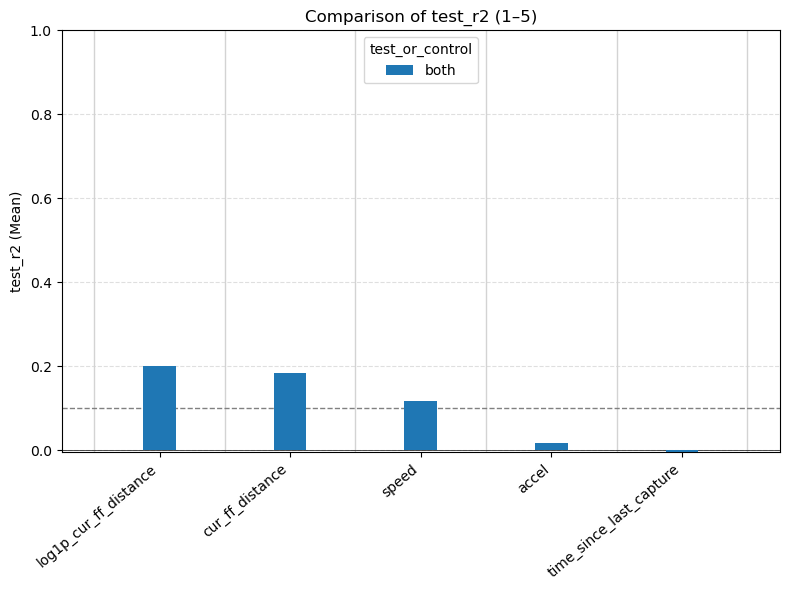

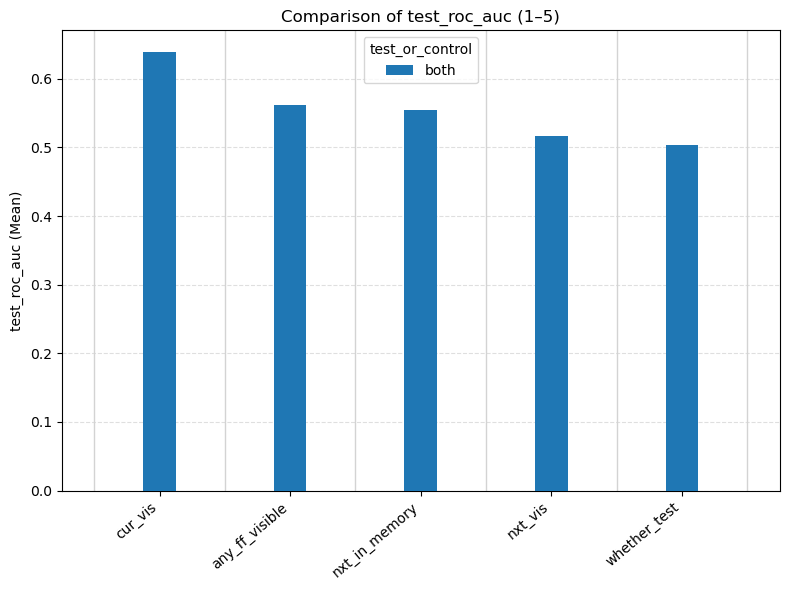

data_0330
Loaded binned_spikes_df from all_monkey_data/processed_neural_data/monkey_Bruno/data_0330/binned_spikes_df_0p1.csv
Loaded planning_data_by_point from all_monkey_data/planning_and_neural/monkey_Bruno/data_0330/planning_data_by_point/opt_arc_stop_closest/test/cur_vis_0_1_window_-25cm_0cm
Loaded planning_data_by_point from all_monkey_data/planning_and_neural/monkey_Bruno/data_0330/planning_data_by_point/opt_arc_stop_closest/control/cur_vis_0_1_window_-25cm_0cm
Loaded behav_data_by_bin from all_monkey_data/target_decoder/monkey_Bruno/data_0330/behav_data_by_point.csv
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Dropped 7 columns with more than 50.0% missing values: ['stop_id_duration', 'stop_cluster_size', 'stop_id_start_time', 'stop_cluster_start_point', 'stop_cluster_id', 'stop_cluster_end_point', 'stop_id_end_time']
0.24% of rows are dropped in plan

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)
/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the g

x_var.shape: (9417, 18)
y_var.shape: (9417, 37)
x_var_reduced.shape: (9417, 18)
y_var_reduced.shape: (9417, 34)
x_var_lags.shape: (9417, 189)
y_var_lags.shape: (9417, 398)
new_seg_duration is now 1.0, and post_event_window is now 0.75
Loaded new_seg_info from all_monkey_data/planning_and_neural/monkey_Bruno/data_0330/new_seg_info/tlim2_cur_first_pre0p25_post0p75.csv
Dropped 43 columns due to containing NA in rebinned_y_var via calling drop_na_cols function: ['cur_opt_arc_curv', 'cur_cntr_arc_curv', 'nxt_cntr_arc_curv', 'nxt_opt_arc_curv', 'cur_opt_arc_end_heading', 'angle_opt_cur_end_to_nxt_ff', 'angle_from_stop_to_nxt_ff', 'diff_in_angle_to_nxt_ff', 'diff_in_abs_angle_to_nxt_ff', 'traj_curv_to_stop', 'curv_from_stop_to_nxt_ff', 'opt_curv_to_cur_ff', 'curv_from_cur_end_to_nxt_ff', 'd_curv_null_arc', 'd_curv_monkey', 'abs_d_curv_null_arc', 'abs_d_curv_monkey', 'diff_in_d_curv', 'diff_in_abs_d_curv', 'abs_angle_opt_cur_end_to_nxt_ff', 'abs_angle_from_stop_to_nxt_ff', 'abs_diff_in_angle_t

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)


Made rebinned_x_var, rebinned_y_var, rebinned_x_var_lags, and rebinned_y_var_lags.

No NA values found in concat_neural_trials

No NA values found in concat_behav_trials
Rank deficiency detected: 2 redundant neurons
Matrix shape: (353, 64), Rank: 62
Smallest singular values:
[0.      0.      0.19672 0.42579 0.54161]
Dropping redundant neuron: cluster_6_-2
Rank deficiency detected: 1 redundant neurons
Matrix shape: (353, 63), Rank: 62
Smallest singular values:
[0.      0.19672 0.41909 0.54161 0.74482]
Dropping redundant neuron: cluster_13_0

No NA values found in concat_neural_trials

No NA values found in concat_behav_trials

=== Data Dimensions Summary ===
Total number of trials: 353

Concatenated Data Shapes (total n_timepoints × n_features):
  concat_neural_trials:     (3468, 64)
  concat_behav_trials:      (3468, 33)
test_or_control: both
x_var dimensions: (2425, 62)
y_var dimensions: (2425, 33)


/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

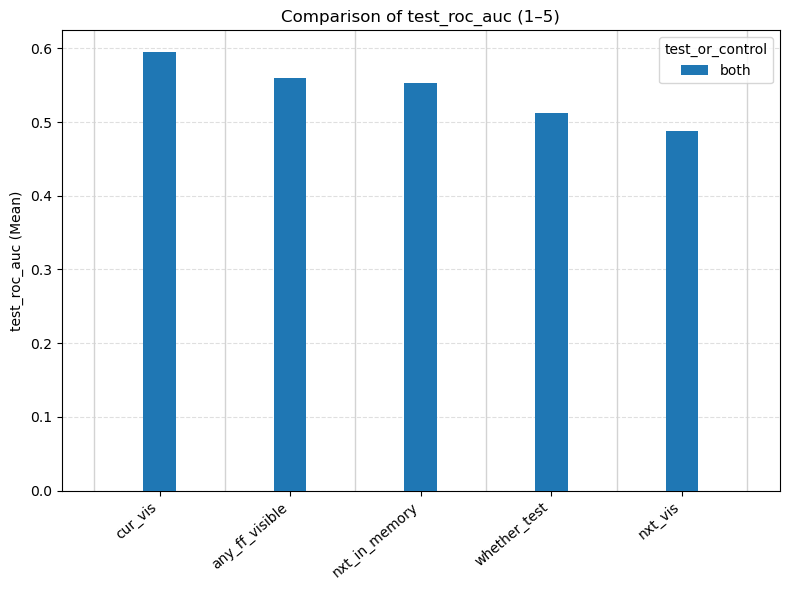

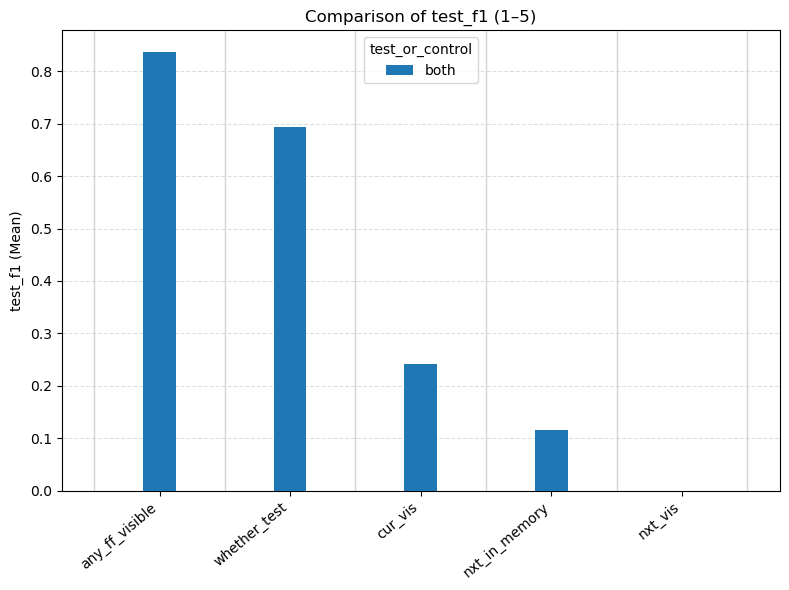

data_0402
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Retrieved ff_dataframe from all_monkey_data/processed_data/monkey_Bruno/data_0402/ff_dataframe.h5
Made new binned_spikes_df and saved to all_monkey_data/processed_neural_data/monkey_Bruno/data_0402/binned_spikes_df_0p1.csv
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Removed 0 rows out of 725 rows where cur_ff was not visible bbas or nxt_ff was not visible both bbas and bsans
shared_stops_near_ff_df has 725 rows
Retrieving shared_stops_near_ff_df succeeded
[Warning] 6.868% of ff_x_relative > ff_y_relative. Rows will be removed.
[Warning] 0.300% of ff_x_relative > ff_y_relative. Rows will be removed.
Failed to retrieve heading_info_df because Failed to retrieve diff_in_curv_df:

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)
/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the g

x_var.shape: (8253, 17)
y_var.shape: (8253, 37)
x_var_reduced.shape: (8253, 17)
y_var_reduced.shape: (8253, 34)
x_var_lags.shape: (8253, 178)
y_var_lags.shape: (8253, 398)
new_seg_duration is now 1.0, and post_event_window is now 0.75
Dropped 264 out of 591 segments because of insufficient duration, which is 44.7% of all segments
Made new new_seg_info and saved to all_monkey_data/planning_and_neural/monkey_Bruno/data_0402/new_seg_info/tlim2_cur_first_pre0p25_post0p75.csv
Dropped 43 columns due to containing NA in rebinned_y_var via calling drop_na_cols function: ['nxt_cntr_arc_curv', 'nxt_opt_arc_curv', 'cur_opt_arc_curv', 'cur_cntr_arc_curv', 'cur_opt_arc_end_heading', 'angle_opt_cur_end_to_nxt_ff', 'angle_from_stop_to_nxt_ff', 'diff_in_angle_to_nxt_ff', 'diff_in_abs_angle_to_nxt_ff', 'traj_curv_to_stop', 'curv_from_stop_to_nxt_ff', 'opt_curv_to_cur_ff', 'curv_from_cur_end_to_nxt_ff', 'd_curv_null_arc', 'd_curv_monkey', 'abs_d_curv_null_arc', 'abs_d_curv_monkey', 'diff_in_d_curv', 'di

/user_data/cicid/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/neural_analysis_tools/get_neural_data/neural_data_processing.py:262: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'lag_segment_id', group_keys=False).apply(lag_group)



No NA values found in concat_neural_trials

No NA values found in concat_behav_trials
Rank deficiency detected: 1 redundant neurons
Matrix shape: (327, 60), Rank: 59
Smallest singular values:
[0.      0.21719 0.42706 0.53085 0.58988]
Dropping redundant neuron: cluster_2_-2

No NA values found in concat_neural_trials

No NA values found in concat_behav_trials

=== Data Dimensions Summary ===
Total number of trials: 327

Concatenated Data Shapes (total n_timepoints × n_features):
  concat_neural_trials:     (3233, 61)
  concat_behav_trials:      (3233, 33)
test_or_control: both
x_var dimensions: (2261, 59)
y_var dimensions: (2261, 33)


/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cicid/miniconda3/envs/multiff_clean/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


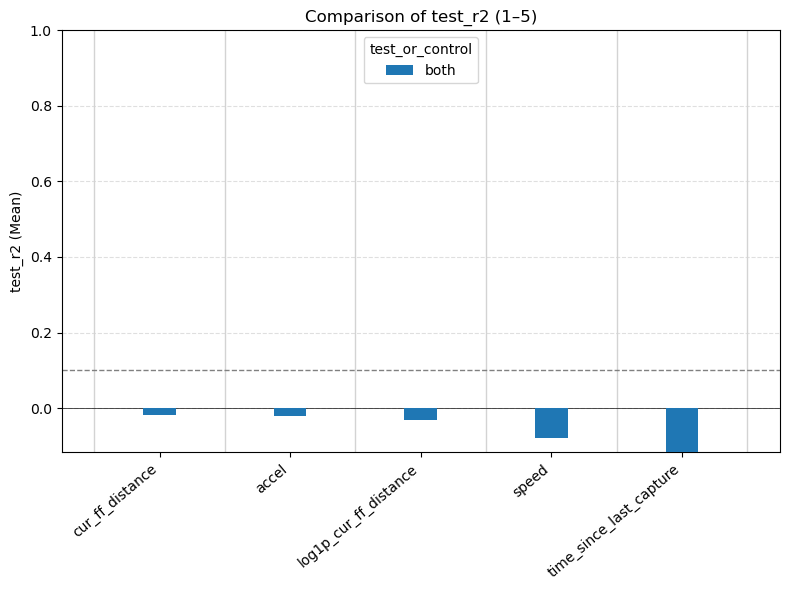

In [ ]:
raw_data_dir_name = 'all_monkey_data/raw_monkey_data'

sessions_df_for_one_monkey = combine_info_utils.make_sessions_df_for_one_monkey(
    raw_data_dir_name, 'monkey_Bruno')

for index, row in sessions_df_for_one_monkey.iterrows():
    print('='*100)
    print('='*100)
    print(row['data_name'])
    raw_data_folder_path = os.path.join(
        raw_data_dir_name, row['monkey_name'], row['data_name'])
    
    reduce_y_var_lags = False
    planning_data_by_point_exists_ok = True
    y_data_exists_ok = True
    bin_width = 0.1
    
    try:
        pn = pn_aligned_by_event.PlanningAndNeuralEventAligned(raw_data_folder_path=raw_data_folder_path, bin_width=bin_width)
        pn.prep_data_to_analyze_planning(planning_data_by_point_exists_ok=planning_data_by_point_exists_ok)
        pn.planning_data_by_point, cols_to_drop = general_utils.drop_columns_with_many_nans(
            pn.planning_data_by_point)
        pn.get_x_and_y_data_for_modeling(exists_ok=y_data_exists_ok, reduce_y_var_lags=reduce_y_var_lags)
        
            
        pn.prepare_seg_aligned_data()
        if not use_raw_spike_data_instead:
            pn.get_gpfa_traj(latent_dimensionality=7, exists_ok=True)

        # for regression later
        use_lagged_rebinned_behav_data = False
        pn.get_concat_data_for_regression(use_raw_spike_data_instead=use_raw_spike_data_instead,
                                        use_lagged_rebinned_behav_data=use_lagged_rebinned_behav_data,
                                        apply_pca_on_raw_spike_data=apply_pca_on_raw_spike_data,
                                        use_lagged_raw_spike_data=use_lagged_raw_spike_data,) 


        pn.concat_behav_trials = _prep_behav(pn.concat_behav_trials, key_feats)
        pn.rebinned_behav_data = _prep_behav(pn.rebinned_behav_data, key_feats)
        pn.print_data_dimensions()
        
        mask = pn.concat_behav_trials['bin_mid_time_rel_to_event'] > 0
        pn.concat_behav_trials = pn.concat_behav_trials[mask]
        pn.concat_neural_trials = pn.concat_neural_trials[mask]
        
        

        pn.separate_test_and_control_data()
        # columns_of_interest = ['whether_test', 'cur_ff_distance', 'cur_ff_angle', 'nxt_ff_distance', 'nxt_ff_rel_y', 'nxt_opt_arc_dheading', 'nxt_ff_rel_x', 'nxt_ff_angle', 'nxt_ff_angle_at_ref']
        columns_of_interest = pn.concat_behav_trials.columns
        all_results = []
        for test_or_control in ['both']: #['test', 'control', 'both']:
            x_var, y_var = pn.get_concat_x_and_y_var_for_lr(test_or_control=test_or_control)
            
            results_summary = ml_methods_utils.run_segment_split_regression_cv(
                x_var, 
                y_var, 
                columns_of_interest, 
                num_folds=5, 
            )
            results_summary['test_or_control'] = test_or_control
            all_results.append(results_summary)

        all_results = pd.concat(all_results)
        all_results.head()

        reg_results = all_results[all_results['Model'] == 'Linear Regression']
        class_results = all_results[all_results['Model'] == 'Logistic Regression']

        # first only plot key_features cur_ff_distance
        key_features = ['cur_ff_distance', 'log1p_cur_ff_distance', 'speed', 'accel', 'time_since_last_capture']
        for metric in ['test_r2']:
            ml_methods_utils.make_barplot_to_compare_results(
                    reg_results, 
                    metric=metric, 
                    features=key_features,
                )
            print('='*100)
            print('='*100)


        rest_of_features = [c for c in reg_results['Feature'].unique() if c not in key_features]

        # regression results
        for metric in ['test_r2']:
            ml_methods_utils.make_barplot_to_compare_results(
                    reg_results, 
                    metric=metric, 
                    features=rest_of_features,
                )
            print('='*100)
            print('='*100)
            
        # classification results
        for metric in ['test_roc_auc']:
            ml_methods_utils.make_barplot_to_compare_results(
                class_results, 
                metric=metric, 
            )
            
    except Exception as e:
        print(f"Error processing {row['data_name']}: {e}")
        continue

    # Save the current state of the notebook
    